# Importing libraries

In [60]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import AgglomerativeClustering
from transformers import AutoTokenizer, AutoModel
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import torch
import nltk
from lazypredict.Supervised import LazyClassifier
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import string
from wordcloud import WordCloud
from nltk import bigrams
from nltk.collocations import BigramAssocMeasures
from nltk.probability import FreqDist
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
# visualization
import pyLDAvis
import pyLDAvis.gensim_models
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import networkx as nx
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB, GaussianNB, MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import loguniform
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Unlabeled data bq-results-20230912-113230-1694518407919

In [3]:
df = pd.read_csv('bq-results-20230912-113230-1694518407919.csv')
df

filename  \
0      SOM_118_00513_FA163E622DEB-1a7e-e29da700-832c3...   
1      SOM_118_00513_FA163E52FD32-1a7e-2da87700-aa52c...   
2      SOM_118_00513_FA163ED88855-1b1d-62522700-9f3ab...   
3      SOM_118_00514_FA163E622DEB-1a7e-e61e1700-87f84...   
4      SOM_118_00259_FA163E52FD32-1a7e-2da87700-a5517...   
...                                                  ...   
64530  SOM_VYD_-0001_FA163E56E95C-5e28-26ff4700-25e26...   
64531  SOM_VYD_-0001_FA163E52FD32-1a7e-3028c700-7a142...   
64532  SOM_VYD_-0001_FA163E622DEB-1a7e-e41dd700-88d9b...   
64533  SOM_VYD_-0001_FA163E44569D-1a89-b144b700-8492d...   
64534  SOM_VYD_-0001_FA163ED88855-1b1d-62522700-a36c8...   

                                                 content  SOM location  \
0      Herzlich willkommen bei O sein uns am Apparat ...  SOM      118   
1      Willkommen bei der O Kundenbetreuung sie sprec...  SOM      118   
2      Herzlich Willkommen hier ist die DSL und Techn...  SOM      118   
3      Hallo schönen guten Tag herzlich willkommen be...  SOM      118   
4      Willkommen bei O so langsam Apparat\nEs ging e...  SOM      118   
...                                                  ...  ...      ...   
64530  Können sie mich hören hallo ja hallo ich habe ...  SOM      VYD   
64531  Wunderschönen guten Tag und herzlich willkomme...  SOM      VYD   
64532  Ja hallo mein Name ist Ari guten sie mit so un...  SOM      VYD   
64533  Herr Müller sehr guten tag die Kollegin hat mi...  SOM      VYD   
64534  Herr Schreiber to mein Name ist Nicola was kan...  SOM      VYD   

       call_duration                                Ariadne_internal_ID  
0                513  FA163E622DEB-1a7e-e29da700-832c3-64e3520f-7cef...  
1                513  FA163E52FD32-1a7e-2da87700-aa52c-64e76b65-aec3...  
2                513  FA163ED88855-1b1d-62522700-9f3ab-64e5fe14-2206...  
3                514  FA163E622DEB-1a7e-e61e1700-87f84-64e5d698-d607...  
4                259  FA163E52FD32-1a7e-2da87700-a5517-64e5eed0-89ea...  
...              ...                                                ...  
64530             -1  FA163E56E95C-5e28-26ff4700-25e26-64e8d8b1-9987...  
64531             -1  FA163E52FD32-1a7e-3028c700-7a142-64e46468-1225...  
64532             -1  FA163E622DEB-1a7e-e41dd700-88d9b-64e70e8f-3d3a...  
64533             -1  FA163E44569D-1a89-b144b700-8492d-64e70077-5731...  
64534             -1  FA163ED88855-1b1d-62522700-a36c8-64e748ad-7a74...  

[64535 rows x 6 columns]

# Data preprocessing

In [4]:
# Check for missing data in the entire DataFrame
missing_data = df.isnull().sum()

# Print missing data counts for each column
print("Missing Data Counts:")
print(missing_data)


Missing Data Counts:
filename               0
content                0
SOM                    0
location               0
call_duration          0
Ariadne_internal_ID    0
dtype: int64


In [5]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

# Print duplicate rows
print("Duplicate Rows:")
print(duplicate_rows)

Duplicate Rows:
Empty DataFrame
Columns: [filename, content, SOM, location, call_duration, Ariadne_internal_ID]
Index: []


In [6]:
nlp = spacy.load('de_core_news_sm')
df['text'] = df['content'].apply(lambda x: ' '.join([token.text for token in nlp(x) if token.pos_!='PROPN']))

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

In [7]:
# Download the NLTK stop words list and wordnet for lemmatization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the Snowball stemmer and WordNet lemmatizer
stemmer = SnowballStemmer("german")  # Use the appropriate language for stemming
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    tokens = [word.replace(".", "") for word in tokens]
    tokens = [word.replace("\n", "") for word in tokens]
    tokens = [word.replace(",", "") for word in tokens]
    tokens = [word.replace(",", "") for word in tokens]
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('german'))  # Use the appropriate language
    tokens = [word for word in tokens if word not in stop_words]
    
    # Remove short words (length < 3 characters)
    tokens = [word for word in tokens if len(word) > 2]
    
    # Lemmatize or stem the words
    # Uncomment one of the following lines based on your choice
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    
    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the preprocessing function to the DataFrame
df['text'] = df['text'].apply(preprocess_text)

# Print the cleaned DataFrame
print(df['text'])


[nltk_data] Downloading package stopwords to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0        herzlich willkomm apparat tun muss mal guck ko...
1        willkomm kundenbetreu sprech darf tun dat stor...
2        technik abteil braucht kundennumm dat abgleich...
3        schon gut tag herzlich willkomm nam darf tun i...
4        willkomm langsam apparat ging halt rahm suppor...
                               ...                        
64530    hor gerad kolleg gesproch weitergeleitet deswe...
64531    wunderschon gut tag herzlich willkomm ausgezei...
64532    hallo nam ari gut wurd weitergeleitet indizier...
64533    herr gut tag kollegin gesagt problem rout korr...
64534    herr nam tun hallo person kundenkennzahl bitt ...
Name: text, Length: 64535, dtype: object


In [8]:
# get number of unique words:
word_set = set()
for row in df["text"]:
    word_set.update(row.split(" "))

len(word_set)

50629

In [9]:
# select the 100 most frequent words
most_frequent = Counter(" ".join(df["text"]).split()).most_common(100)
print([el[0] for el in most_frequent])

['mal', 'genau', 'schon', 'bitt', 'gut', 'bekomm', 'vertrag', 'dank', 'kurz', 'tag', 'ganz', 'moment', 'sag', 'fall', 'gern', 'numm', 'rufnumm', 'neu', 'monat', 'schau', 'frag', 'seh', 'richtig', 'tun', 'nam', 'tarif', 'geht', 'leid', 'person', 'gesagt', 'war', 'gleich', 'gerad', 'rout', 'kundenkennzahl', 'muss', 'einfach', 'natur', 'willkomm', 'per', 'frau', 'mehr', 'geb', 'nein', 'brauch', 'vielleicht', 'handy', 'imm', 'mocht', 'herzlich', 'klein', 'herr', 'klar', 'kart', 'schick', 'probl', 'syst', 'erst', 'gibt', 'steht', 'wunsch', 'wurd', 'bleib', 'nee', 'sup', 'moglich', 'halt', 'viel', 'angebot', 'seit', 'darf', 'guck', 'internet', 'weit', 'kolleg', 'anruf', 'rabatt', 'weiss', 'gar', 'gemacht', 'rechnung', 'bewert', 'heut', 'adress', 'wart', 'dat', 'gesprach', 'versteh', 'end', 'desweg', 'wirklich', 'bissch', 'zahl', 'krieg', 'bestat', 'wiss', 'beispiel', 'eigent', 'nach', 'tschuss']


In [16]:
# Words to remove
words_to_remove =  most_frequent + ["herr", "hallo", "willkomm", "herzlich", "mal", "tun", "tag", "nam", "guck", "sau", "bitt", 
                                   "halt", "gerad", "weil", "desweg", "gruss", "schon", "abend", "irgendwie", "schau", "nachmittag", "aha",
                                   "gott", "frau", "opus", "herrn", "irgendwo", 'bitt', 'mal', 'schon', 'genau', 'dank', 'gut', 'tag', 'numm', 'person', 'kurz', 
                   'einfach', 'neu', 'schau', 'moment', 'sag', 'muss', 'geht', 'fall', 'ganz', 'war', 'gern', 'frag', 
                   'gleich',
                  'guck', 'imm', 'halt', 'wurd', 'seh', 'natur', 'quasi', 'gerad', 'bekomm', 'rout', 'gesagt', 'nein', 
                   'tun', 'syst',
                  'mehr', 'mocht', 'box', 'geh', 'zugangsdat', 'passwort', 'kennwort', 'steht','seit', 'klein', 'bekomm', 'rufnumm', 
                   'kundenkennzahl', 'leid', 'tun', 'nam', 'per', 'willkomm', 'herzlich', 'gemacht', 'bleib', 'herr',
                   'kolleg',
                   'schick', 'frau', 'geb', 'richtig', 'vielleicht', 'viel','kart', 'brot', 'brauch',
                  'erst', 'gibt', 'kommt', 'moglich',  'pro', 'iphon', 'sekund', 'minut', 'wirklich', 'krieg',
                   'tatsach', 'musst', 'weiss',  'darf', 'find', 'gar', 'probl' , 'nee', 'klar', 'tschuss', 'heut', 'uhr', 'anruf', 
                   'wunsch', 'dat' , 'hallo', 'kundig', 'ich', 'habe']

# Function to remove specified words from text
def remove_specific_words(text, words_to_remove):
    # Tokenize the text
    tokens = text.split(" ")
    
    # Filter out words to remove
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    
    # Join the remaining tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

# Apply the function to the 'cleaned_text' column
df['text'] = df['text'].apply(lambda x: remove_specific_words(x, words_to_remove))

# Print the cleaned DataFrame
print(df['text'])

0        apparat konto aktuell stand ding gemeldet bezu...
1        kundenbetreu sprech storni raus bereit wahrung...
2        technik abteil braucht kundennumm abgleich buc...
3        internet haus funktioniert internet haus vertr...
4        langsam apparat ging rahm support kund gemeins...
                               ...                        
64530    hor gesproch weitergeleitet hochgestuft vertra...
64531    wunderschon ausgezeichnet wichtig technik grow...
64532    ari weitergeleitet indiziert adress postleitza...
64533    kollegin problem korrekt fehlermeld verstand k...
64534    worum rechnung ruf handynumm folgendermass fre...
Name: text, Length: 64535, dtype: object


In [17]:
# Split the 'content' column into words and calculate word counts
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Print the average word count
print("Average Word Count:", average_word_count)

# Calculate the average word count
average_word_count_median = df['word_count'].median()

# Print the average word count
print("Median Word Count:", average_word_count_median)


# Print the max word count
print("Max Word Count:", df['word_count'].max())

# Print the min word count
print("Min Word Count:", df['word_count'].min())

Average Word Count: 108.17444797396762
Median Word Count: 78.0
Max Word Count: 1374
Min Word Count: 1


In [18]:
# Find the text with the minimum number of words
min_word_count = df['word_count'].min()
min_word_text = df[df['word_count'] == min_word_count]['text'].values[0]

# Print the text with the minimum word count
print("Text with the Minimum Number of Words:")
print(min_word_text)

# Optionally, you can also print the word count for reference
print(f"Word Count: {min_word_count}")

Text with the Minimum Number of Words:
lorenz
Word Count: 1


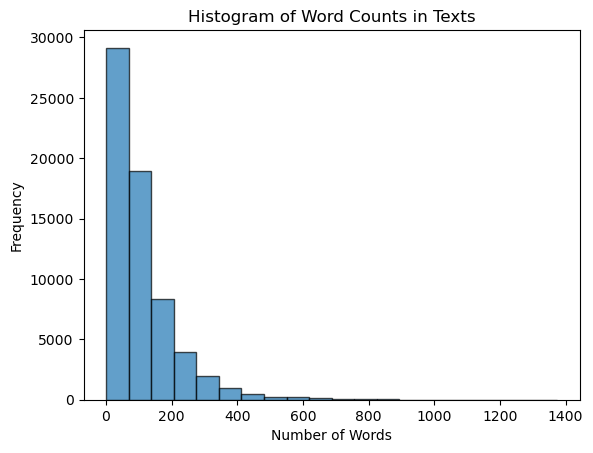

In [19]:
# Create a histogram of the word counts
plt.hist(df['word_count'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in Texts')
plt.show()


# Topic Modelling

In [22]:
# Tokenize the text and create a dictionary
def tokenize(text):
    return text.split()

texts_content = [tokenize(text) for text in df['text']]

# Create a dictionary from the tokenized text
dictionary_content = corpora.Dictionary(texts_content)

# Create document-term matrices
corpus_content = [dictionary_content.doc2bow(text) for text in texts_content]

# Perform LDA
num_topics =5
lda_model_content = gensim.models.LdaModel(corpus=corpus_content, id2word=dictionary_content, num_topics=num_topics)

# Print topics for the 'content' DataFrame
print("Topics for the 'content' DataFrame:")
print(lda_model_content.print_topics(num_words=5))


Topics for the 'content' DataFrame:
[(0, '0.027*"monat" + 0.025*"tarif" + 0.024*"vertrag" + 0.016*"angebot" + 0.014*"rabatt"'), (1, '0.017*"technik" + 0.015*"internet" + 0.011*"leitung" + 0.010*"storung" + 0.010*"funktioniert"'), (2, '0.056*"vertrag" + 0.025*"rechnung" + 0.016*"monat" + 0.010*"end" + 0.010*"alt"'), (3, '0.014*"vertrag" + 0.014*"kundennumm" + 0.014*"adress" + 0.008*"lautet" + 0.008*"versteh"'), (4, '0.022*"handy" + 0.008*"gerat" + 0.007*"sup" + 0.007*"bewert" + 0.007*"link"')]


In [23]:
# Evaluation
coherence_model_content = CoherenceModel(model=lda_model_content, texts=texts_content, dictionary=dictionary_content, coherence='c_v')
coherence_content = coherence_model_content.get_coherence()

# Compute Perplexity a measure of how good the model is. lower the better.
print('\nContent Perplexity: ', lda_model_content.log_perplexity(corpus_content))  

# Compute Coherence Score for lda_model_content

print('\nContent Coherence Score: ', coherence_content)


Content Perplexity:  -7.24842575250442

Content Coherence Score:  0.38829111822382834


C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


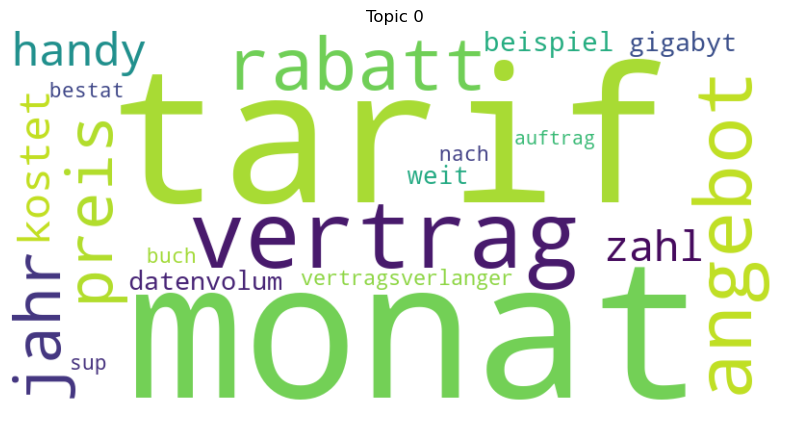

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


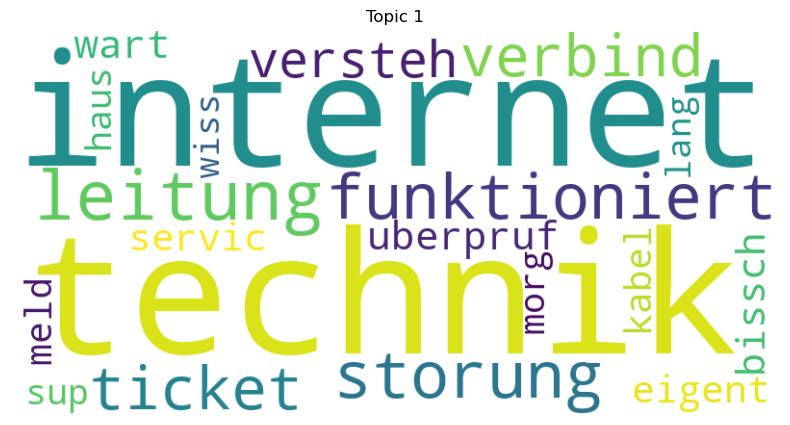

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


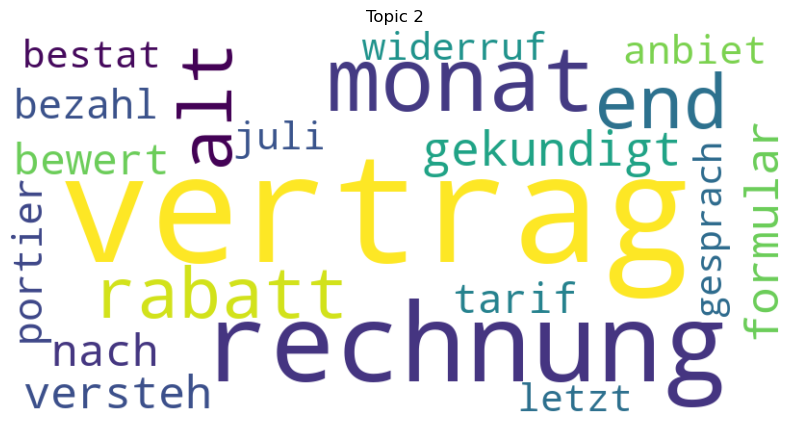

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


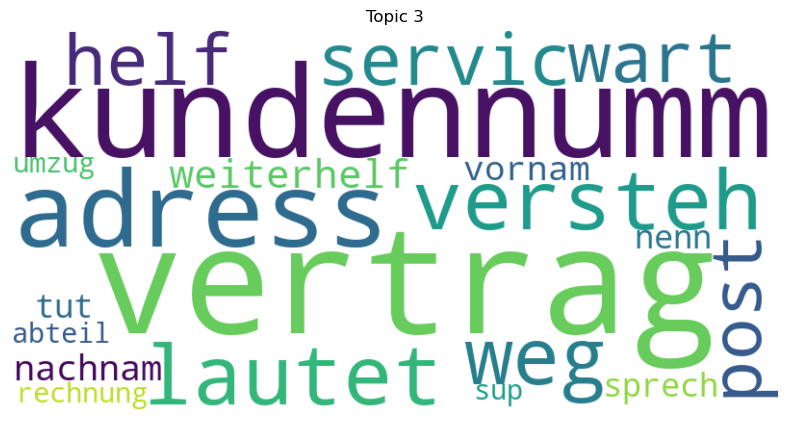

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


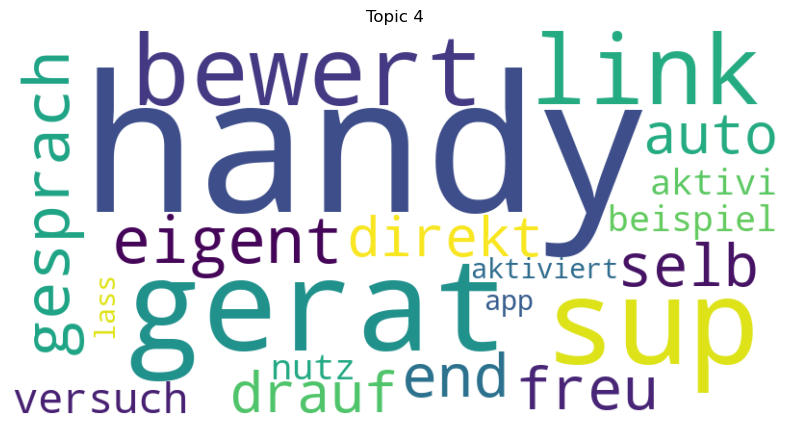

In [24]:
# Create a function to generate and display word clouds for each topic
def generate_word_clouds(lda_model, num_topics):
    for topic_num in range(num_topics):
        words = lda_model.show_topic(topic_num, topn=20)  # Get the top 20 words for each topic
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Topic {topic_num}")
        plt.axis("off")
        plt.show()

# Assuming you have already defined lda_model_content and num_topics
generate_word_clouds(lda_model_content, num_topics)


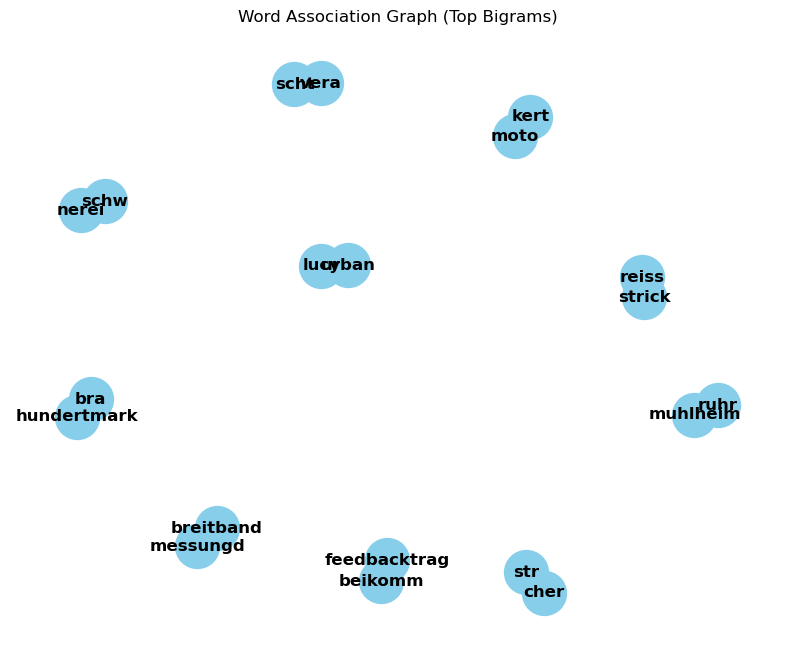

In [25]:
# Assuming you have a list of tokenized texts stored in 'texts_content'
# Join the tokens back into sentences
sentences = [' '.join(tokens) for tokens in texts_content]

# Tokenize the sentences again (if needed)
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

# Create a BigramCollocationFinder
finder = BigramCollocationFinder.from_documents(tokenized_sentences)

# Set the association measure (you can adjust this)
bigram_measures = BigramAssocMeasures()
finder.apply_freq_filter(5)  # Adjust the frequency filter as needed

# Get the top bigrams
top_bigrams = finder.nbest(bigram_measures.pmi, 10)  # You can change the number of top bigrams

# Create a graph to represent word associations
G = nx.Graph()

# Add nodes and edges for the bigrams
for bigram in top_bigrams:
    word1, word2 = bigram
    G.add_node(word1)
    G.add_node(word2)
    G.add_edge(word1, word2)

# Create a figure and axis explicitly
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Define layout for the nodes
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, font_size=12, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold', ax=ax)
plt.title("Word Association Graph (Top Bigrams)")
plt.show()


# Labeled data 231106_Labeling KI Files_x1121, 1 - 2500 Fertig 1 and 2501 - 5000 final merged

In [29]:
df1 = pd.read_excel('231106_Labeling KI Files_x1121.xlsx')
df1

AP                                Ariadne_internal_ID  \
0            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77b26-64e3046f-1555...   
1            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77d03-64e3074a-24e4...   
2            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77d06-64e3074a-6d7f...   
3            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77d0f-64e30753-8296...   
4            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77d1e-64e30771-785f...   
...                   ...                                                ...   
1116  Anja Haye-Heinemann  FA163E153AE3-1b27-f06ad700-7a9ba-64e4bc6b-797e...   
1117  Anja Haye-Heinemann  FA163E153AE3-1b27-f06ad700-7aa4a-64e4c0fe-55cb...   
1118  Anja Haye-Heinemann  FA163E153AE3-1b27-f06ad700-7aa5c-64e4c193-dba3...   
1119  Anja Haye-Heinemann  FA163E153AE3-1b27-f06ad700-7aa62-64e4c1ab-7103...   
1120  Anja Haye-Heinemann  FA163E153AE3-1b27-f06ad700-7aa7b-64e4c235-f3f0...   

                                                content   cnt  VVL Mobile  \
0     Herzlich willkommen beim O Kundenservice mein ...    54       False   
1     Guten Morgen bei O sie sprechen mit Alexandra ...    61       False   
2     Ackermann fertig willkommen bei O sie sprechen...    62       False   
3     Herzlich willkommen im O Service mein Name ist...    63       False   
4     Guten Morgen herzlich willkommen bei O sie spr...    64       False   
...                                                 ...   ...         ...   
1116  Schönen guten Tag herzlich willkommen bei O hi...  3440       False   
1117  Herzlich willkommen bei blau sie sprechen mit ...  3441       False   
1118  Schönen guten Tag und herzlich willkommen bei ...  3442       False   
1119  Herzlich willkommen bei Rermodus Service Mutz ...  3443       False   
1120  Schönen guten tag herzlich willkommen beim O u...  3444       False   

      VVL DSL  PO GA  I@H GA  TV GA  OOC (out of category)  Comment  \
0       False  False   False  False                  False      NaN   
1       False   True   False  False                  False      NaN   
2       False  False   False  False                  False      NaN   
3       False  False   False  False                  False      NaN   
4       False   True   False  False                  False      NaN   
...       ...    ...     ...    ...                    ...      ...   
1116    False  False   False  False                  False      NaN   
1117    False  False   False  False                  False      NaN   
1118    False  False   False  False                  False      NaN   
1119    False  False   False  False                  False      NaN   
1120    False  False   False  False                  False      NaN   

      Conditional Formatting  
0                          0  
1                          1  
2                          0  
3                          0  
4                          1  
...                      ...  
1116                       0  
1117                       0  
1118                       0  
1119                       0  
1120                       0  

[1121 rows x 12 columns]

In [30]:
df2 = pd.read_excel('2501 - 5000 final.xlsx')
df2

AP                                Ariadne_internal_ID  \
0     Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-8565b-64e47447-a372...   
1     Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-85667-64e47453-3f15...   
2     Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-8566c-64e47453-8b1a...   
3     Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-856a9-64e474d4-8469...   
4     Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-856ce-64e47589-e297...   
...                   ...                                                ...   
2496                  #10  FA163E153AE3-1b27-f16af700-8511d-64e70adc-481f...   
2497                  #10  FA163E153AE3-1b27-f16af700-85120-64e70ae4-b737...   
2498                  #10  FA163E153AE3-1b27-f16af700-85126-64e70ae9-4ca6...   
2499                  #10  FA163E153AE3-1b27-f16af700-85129-64e70aec-376c...   
2500                  #10  FA163E153AE3-1b27-f16af700-85131-64e70aef-1754...   

                                                content   cnt  VVL Mobile  \
0     Willkommen im Service sie sprechen mit sagen w...  2500       False   
1     Willkommen bei O sie sprechen mit den ja Model...  2501       False   
2     Guten Tag und herzlich willkommen bei O sie sp...  2502       False   
3     Herzlich willkommen bei blau sie sprechen mit ...  2503       False   
4     Hallo herzlich willkommen zum O Service schon ...  2504       False   
...                                                 ...   ...         ...   
2496  Willkommen bei deiner Winter guten Morgen\nO. ...  4996       False   
2497  Guten tag herzlich willkommen bei O sie sprech...  4997       False   
2498  O Kundenservice mein Name ist Alexander grüß s...  4998       False   
2499  Guten Tag Remani von O wie kann ich ihnen helf...  4999       False   
2500  Herzlich willkommen im aufgezeichnet O Service...  5000       False   

      VVL DSL  PO GA  I@H GA  TV GA  OOC (out of category)  Comment  \
0       False  False   False  False                  False      NaN   
1       False  False   False  False                  False      NaN   
2       False  False   False  False                  False      NaN   
3       False  False   False  False                  False      NaN   
4       False  False   False  False                  False      NaN   
...       ...    ...     ...    ...                    ...      ...   
2496    False  False   False  False                  False      NaN   
2497    False  False   False  False                  False      NaN   
2498    False  False   False  False                  False      NaN   
2499    False  False   False  False                  False      NaN   
2500    False  False   False  False                  False      NaN   

      Conditional Formatting  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  
...                      ...  
2496                       0  
2497                       0  
2498                       0  
2499                       0  
2500                       0  

[2501 rows x 12 columns]

In [136]:
df3 = pd.read_excel('1 - 2500 Fertig 1.xlsx')
df3

AP                                Ariadne_internal_ID  \
0                      #1  FA163E153AE3-1b27-eeeaa700-77a99-64e303f9-7f87...   
1                      #1  FA163E153AE3-1b27-eeeaa700-77627-64e2f5cc-48cf...   
2                      #1  FA163E153AE3-1b27-eeeaa700-77b08-64e30452-bfad...   
3                      #1  FA163E153AE3-1b27-eeeaa700-77a72-64e303dd-c261...   
4                      #1  FA163E153AE3-1b27-eeeaa700-77a39-64e3039c-30dc...   
...                   ...                                                ...   
2495  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-8560b-64e47402-8933...   
2496  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-85631-64e4742c-7691...   
2497  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-85655-64e47444-e02f...   
2498  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-85658-64e47447-7a4a...   
2499  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-8565b-64e47447-a372...   

                                                content   cnt  VVL Mobile  \
0     Hallo guten Morgen herzlich willkommen bei O m...    42       False   
1     Hallo herzlich willkommen bei der Service sie ...     6       False   
2     Hallo guten Tag willkommen bei O Kundenservice...    50       False   
3     Herzlich willkommen bei O sie sprechen mit Her...    38       False   
4     Hallo schönen guten Tag mein Name ist Chris We...    34       False   
...                                                 ...   ...         ...   
2495  Ja hallo schönen guten Tag herzlich willkommen...  2496       False   
2496  Schönen guten tag Reiner Mohammad von O Kunden...  2497       False   
2497  Herzlich kommen wir mal ausgeseien Service Tel...  2498       False   
2498  O Kundenservice mein Name was darf ich für Sie...  2499       False   
2499  Willkommen im Service sie sprechen mit sagen w...  2500       False   

      VVL DSL  PO GA  I@H GA  TV GA  OOC (out of category)  Comment  \
0       False  False   False  False                  False      NaN   
1       False  False   False  False                  False      NaN   
2       False  False   False  False                  False      NaN   
3       False  False   False  False                  False      NaN   
4       False  False   False  False                  False      NaN   
...       ...    ...     ...    ...                    ...      ...   
2495    False  False   False  False                  False      NaN   
2496    False  False   False  False                  False      NaN   
2497    False  False   False  False                  False      NaN   
2498    False  False   False  False                  False      NaN   
2499    False  False   False  False                  False      NaN   

      Conditional Formatting Bearbeitungszeit  
0                          0         00:05:00  
1                          0         00:06:00  
2                          0         00:08:00  
3                          0         00:10:00  
4                          0         00:17:00  
...                      ...              ...  
2495                       0              NaN  
2496                       0              NaN  
2497                       0              NaN  
2498                       0              NaN  
2499                       0              NaN  

[2500 rows x 13 columns]

In [142]:

# Concatenate the DataFrames along the rows
df = pd.concat([df1, df2, df3], ignore_index=True)

df

AP                                Ariadne_internal_ID  \
0            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77b26-64e3046f-1555...   
1            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77d03-64e3074a-24e4...   
2            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77d06-64e3074a-6d7f...   
3            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77d0f-64e30753-8296...   
4            Katrin Kühne  FA163E153AE3-1b27-eeeaa700-77d1e-64e30771-785f...   
...                   ...                                                ...   
6117  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-8560b-64e47402-8933...   
6118  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-85631-64e4742c-7691...   
6119  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-85655-64e47444-e02f...   
6120  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-85658-64e47447-7a4a...   
6121  Anja Haye-Heinemann  FA163E153AE3-1b27-efeac700-8565b-64e47447-a372...   

                                                content   cnt  VVL Mobile  \
0     Herzlich willkommen beim O Kundenservice mein ...    54       False   
1     Guten Morgen bei O sie sprechen mit Alexandra ...    61       False   
2     Ackermann fertig willkommen bei O sie sprechen...    62       False   
3     Herzlich willkommen im O Service mein Name ist...    63       False   
4     Guten Morgen herzlich willkommen bei O sie spr...    64       False   
...                                                 ...   ...         ...   
6117  Ja hallo schönen guten Tag herzlich willkommen...  2496       False   
6118  Schönen guten tag Reiner Mohammad von O Kunden...  2497       False   
6119  Herzlich kommen wir mal ausgeseien Service Tel...  2498       False   
6120  O Kundenservice mein Name was darf ich für Sie...  2499       False   
6121  Willkommen im Service sie sprechen mit sagen w...  2500       False   

      VVL DSL  PO GA  I@H GA  TV GA  OOC (out of category)  Comment  \
0       False  False   False  False                  False      NaN   
1       False   True   False  False                  False      NaN   
2       False  False   False  False                  False      NaN   
3       False  False   False  False                  False      NaN   
4       False   True   False  False                  False      NaN   
...       ...    ...     ...    ...                    ...      ...   
6117    False  False   False  False                  False      NaN   
6118    False  False   False  False                  False      NaN   
6119    False  False   False  False                  False      NaN   
6120    False  False   False  False                  False      NaN   
6121    False  False   False  False                  False      NaN   

      Conditional Formatting Bearbeitungszeit  
0                          0              NaN  
1                          1              NaN  
2                          0              NaN  
3                          0              NaN  
4                          1              NaN  
...                      ...              ...  
6117                       0              NaN  
6118                       0              NaN  
6119                       0              NaN  
6120                       0              NaN  
6121                       0              NaN  

[6122 rows x 13 columns]

# Data preprocessing

In [143]:
df.columns

Index(['AP', 'Ariadne_internal_ID', 'content', 'cnt', 'VVL Mobile', 'VVL DSL',
       'PO GA', 'I@H GA', 'TV GA', 'OOC (out of category)', 'Comment',
       'Conditional Formatting', 'Bearbeitungszeit'],
      dtype='object')

In [144]:
# Check for missing data in the entire DataFrame
missing_data = df.isnull().sum()

# Print missing data counts for each column
print("Missing Data Counts:")
print(missing_data)

Missing Data Counts:
AP                           0
Ariadne_internal_ID          0
content                      0
cnt                          0
VVL Mobile                   0
VVL DSL                      0
PO GA                        0
I@H GA                       0
TV GA                        0
OOC (out of category)        0
Comment                   6122
Conditional Formatting       0
Bearbeitungszeit          6062
dtype: int64


In [145]:
# List of columns to remove
columns_to_remove = ['AP','Ariadne_internal_ID','cnt','OOC (out of category)', 'Comment', 'Conditional Formatting', 'Bearbeitungszeit']

# Drop the specified columns
df = df.drop(columns=columns_to_remove)

# Display the DataFrame after removing columns
df


content  VVL Mobile  VVL DSL  \
0     Herzlich willkommen beim O Kundenservice mein ...       False    False   
1     Guten Morgen bei O sie sprechen mit Alexandra ...       False    False   
2     Ackermann fertig willkommen bei O sie sprechen...       False    False   
3     Herzlich willkommen im O Service mein Name ist...       False    False   
4     Guten Morgen herzlich willkommen bei O sie spr...       False    False   
...                                                 ...         ...      ...   
6117  Ja hallo schönen guten Tag herzlich willkommen...       False    False   
6118  Schönen guten tag Reiner Mohammad von O Kunden...       False    False   
6119  Herzlich kommen wir mal ausgeseien Service Tel...       False    False   
6120  O Kundenservice mein Name was darf ich für Sie...       False    False   
6121  Willkommen im Service sie sprechen mit sagen w...       False    False   

      PO GA  I@H GA  TV GA  
0     False   False  False  
1      True   False  False  
2     False   False  False  
3     False   False  False  
4      True   False  False  
...     ...     ...    ...  
6117  False   False  False  
6118  False   False  False  
6119  False   False  False  
6120  False   False  False  
6121  False   False  False  

[6122 rows x 6 columns]

In [146]:
# Remove proper noun from text 
nlp = spacy.load('de_core_news_sm')
df['text'] = df['content'].apply(lambda x: ' '.join([token.text for token in nlp(x) if token.pos_!='PROPN']))

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\catalogue\__init__.py:123: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
C:\Users\Muhammad Farhan\anaconda\Lib\site-p

In [147]:
# Download the NLTK stop words list and wordnet for lemmatization
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the Snowball stemmer and WordNet lemmatizer
stemmer = SnowballStemmer("german")  # Use the appropriate language for stemming
lemmatizer = WordNetLemmatizer()

# Define a function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    tokens = [word.replace(".", "") for word in tokens]
    tokens = [word.replace("\n", "") for word in tokens]
    tokens = [word.replace(",", "") for word in tokens]
    tokens = [word.replace(",", "") for word in tokens]
    tokens = [word.lower() for word in tokens if word.isalnum()]
    
    # Remove stopwords
    stop_words = set(stopwords.words('german'))  # Use the appropriate language
    tokens = [word for word in tokens if word not in stop_words]
    
    # Remove short words (length < 3 characters)
    tokens = [word for word in tokens if len(word) > 2]
    
    # Lemmatize or stem the words
    # Uncomment one of the following lines based on your choice
    # tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    
    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the preprocessing function to the DataFrame
df['text'] = df['text'].apply(preprocess_text)

# Print the cleaned DataFrame
df['text']


[nltk_data] Downloading package stopwords to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Muhammad
[nltk_data]     Farhan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       herzlich willkomm beim kundenservic nam gruss ...
1       gut morg sprech rout helf geht angegeb rufnumm...
2       fertig willkomm sprech tun handy abgeschloss v...
3       herzlich willkomm servic nam darf tun herr bit...
4       gut morg herzlich willkomm sprech valeri versc...
                              ...                        
6117    hallo schon gut tag herzlich willkomm auto tar...
6118    schon gut tag darf tun rufnumm numm anruf heis...
6119    herzlich komm mal ausgesei servic euro tun dau...
6120    nam darf tun guck mal schnell mal bitt kurz vo...
6121    willkomm servic sprech sag tun schau mal natur...
Name: text, Length: 6122, dtype: object

In [148]:
# get number of unique words:
word_set = set()
for row in df["text"]:
    word_set.update(row.split(" "))

len(word_set)

15318

In [149]:
# select the 100 most frequent words
most_frequent = Counter(" ".join(df["text"]).split()).most_common(100)
print([el[0] for el in most_frequent])

['mal', 'genau', 'schon', 'bitt', 'gut', 'vertrag', 'bekomm', 'dank', 'kurz', 'ganz', 'tag', 'fall', 'sag', 'moment', 'gern', 'monat', 'numm', 'neu', 'rufnumm', 'schau', 'frag', 'richtig', 'seh', 'tarif', 'tun', 'nam', 'geht', 'war', 'leid', 'person', 'gesagt', 'gerad', 'gleich', 'natur', 'rout', 'muss', 'einfach', 'kundenkennzahl', 'willkomm', 'per', 'mehr', 'frau', 'geb', 'handy', 'brauch', 'vielleicht', 'nein', 'klein', 'herr', 'herzlich', 'probl', 'imm', 'mocht', 'klar', 'erst', 'kart', 'schick', 'syst', 'gibt', 'halt', 'steht', 'wunsch', 'moglich', 'viel', 'angebot', 'sup', 'bleib', 'wurd', 'nee', 'seit', 'rabatt', 'darf', 'guck', 'weit', 'anruf', 'kolleg', 'adress', 'weiss', 'gar', 'rechnung', 'internet', 'dat', 'bewert', 'heut', 'gemacht', 'wart', 'beispiel', 'bissch', 'gesprach', 'end', 'versteh', 'krieg', 'wirklich', 'zahl', 'nach', 'tschuss', 'bestat', 'eigent', 'wiss', 'sprech']


In [150]:
# Words to remove
words_to_remove =  most_frequent + ["herr", "hallo", "willkomm", "herzlich", "mal", "tun", "tag", "nam", "guck", "sau", "bitt", 
                                   "halt", "gerad", "weil", "desweg", "gruss", "schon", "abend", "irgendwie", "schau", "nachmittag", "aha",
                                   "gott", "frau", "opus", "herrn", "irgendwo", 'bitt', 'mal', 'schon', 'genau', 'dank', 'gut', 'tag', 'numm', 'person', 'kurz', 
                   'einfach', 'neu', 'schau', 'moment', 'sag', 'muss', 'geht', 'fall', 'ganz', 'war', 'gern', 'frag', 
                   'gleich',
                  'guck', 'imm', 'halt', 'wurd', 'seh', 'natur', 'quasi', 'gerad', 'bekomm', 'rout', 'gesagt', 'nein', 
                   'tun', 'syst',
                  'mehr', 'mocht', 'box', 'geh', 'zugangsdat', 'passwort', 'kennwort', 'steht','seit', 'klein', 'bekomm', 'rufnumm', 
                   'kundenkennzahl', 'leid', 'tun', 'nam', 'per', 'willkomm', 'herzlich', 'gemacht', 'bleib', 'herr',
                   'kolleg',
                   'schick', 'frau', 'geb', 'richtig', 'vielleicht', 'viel','kart', 'brot', 'brauch',
                  'erst', 'gibt', 'kommt', 'moglich',  'pro', 'iphon', 'sekund', 'minut', 'wirklich', 'krieg',
                   'tatsach', 'musst', 'weiss',  'darf', 'find', 'gar', 'probl' , 'nee', 'klar', 'tschuss', 'heut', 'uhr', 'anruf', 
                   'wunsch', 'dat' , 'hallo', 'kundig', 'ich', 'habe']

# Function to remove specified words from text
def remove_specific_words(text, words_to_remove):
    # Tokenize the text
    tokens = text.split(" ")
    
    # Filter out words to remove
    filtered_tokens = [word for word in tokens if word not in words_to_remove]
    
    # Join the remaining tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    
    return cleaned_text

# Apply the function to the 'cleaned_text' column
df['text'] = df['text'].apply(lambda x: remove_specific_words(x, words_to_remove))

# Print the cleaned DataFrame
df['text']

0       beim kundenservic perfekt funfzig leitung gebu...
1       morg sprech helf angegeb vertragsinhab wart mu...
2       fertig sprech handy abgeschloss vertrag buchst...
3       servic blind planung irgendwann faruk myhom ir...
4       morg sprech valeri verschenk internet pruf kra...
                              ...                        
6117    auto tarif berat sohn alt portiert termin fest...
6118    heiss mittwoch nachnam lautet sich erhalt soll...
6119    komm ausgesei servic euro dauert sich lauft ko...
6120    schnell vollstand gehabt umzug durchfuhr zusam...
6121    servic sprech datenabgleich nenn fix angekomm ...
Name: text, Length: 6122, dtype: object

In [151]:
# Split the 'content' column into words and calculate word counts
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Calculate the average word count
average_word_count = df['word_count'].mean()

# Print the average word count
print("Average Word Count:", average_word_count)

# Calculate the average word count
average_word_count_median = df['word_count'].median()

# Print the average word count
print("Median Word Count:", average_word_count_median)


# Print the max word count
print("Max Word Count:", df['word_count'].max())

# Print the min word count
print("Min Word Count:", df['word_count'].min())

Average Word Count: 110.07366873570729
Median Word Count: 78.0
Max Word Count: 1103
Min Word Count: 2


In [152]:
# Find the text with the minimum number of words
min_word_count = df['word_count'].min()
min_word_text = df[df['word_count'] == min_word_count]['text'].values[0]

# Print the text with the minimum word count
print("Text with the Minimum Number of Words:")
print(min_word_text)

# Optionally, you can also print the word count for reference
print(f"Word Count: {min_word_count}")

Text with the Minimum Number of Words:
kundenbetreu wollt
Word Count: 2


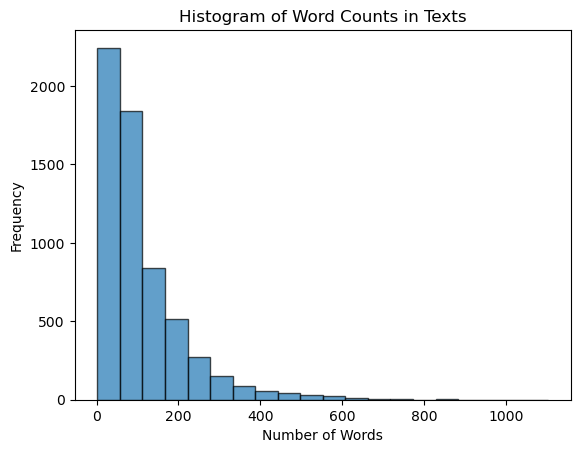

In [153]:
# Create a histogram of the word counts
plt.hist(df['word_count'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts in Texts')
plt.show()


In [ ]:
#Frequency counts for categorical columns

In [154]:
counts_1 = df['VVL Mobile'].value_counts()
counts_2 = df['VVL DSL'].value_counts()
counts_3 = df['PO GA'].value_counts()
counts_4 = df['I@H GA'].value_counts()
counts_5 = df['TV GA'].value_counts()

print(counts_1)
print(counts_2)
print(counts_3)
print(counts_4)
print(counts_5)


VVL Mobile
False    5911
True      211
Name: count, dtype: int64
VVL DSL
False    6096
True       26
Name: count, dtype: int64
PO GA
False    5247
True      875
Name: count, dtype: int64
I@H GA
False    6055
True       67
Name: count, dtype: int64
TV GA
False    6000
True      122
Name: count, dtype: int64


C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


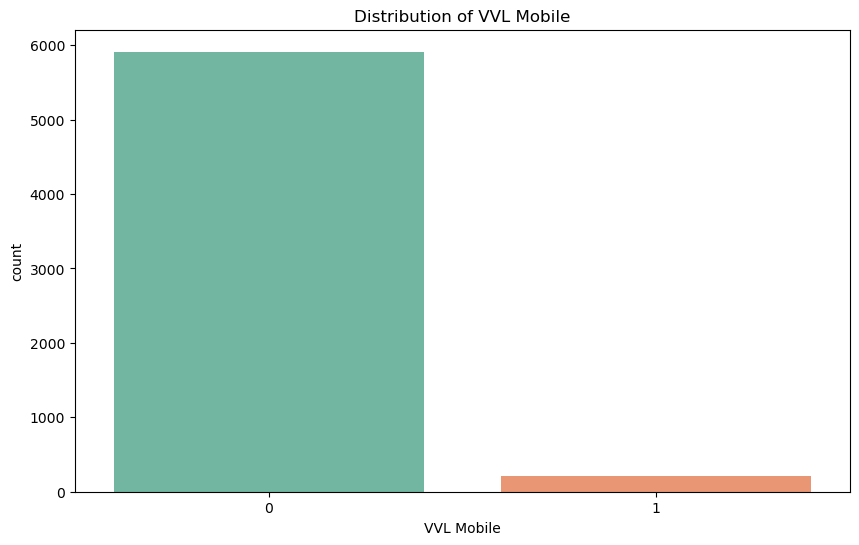

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


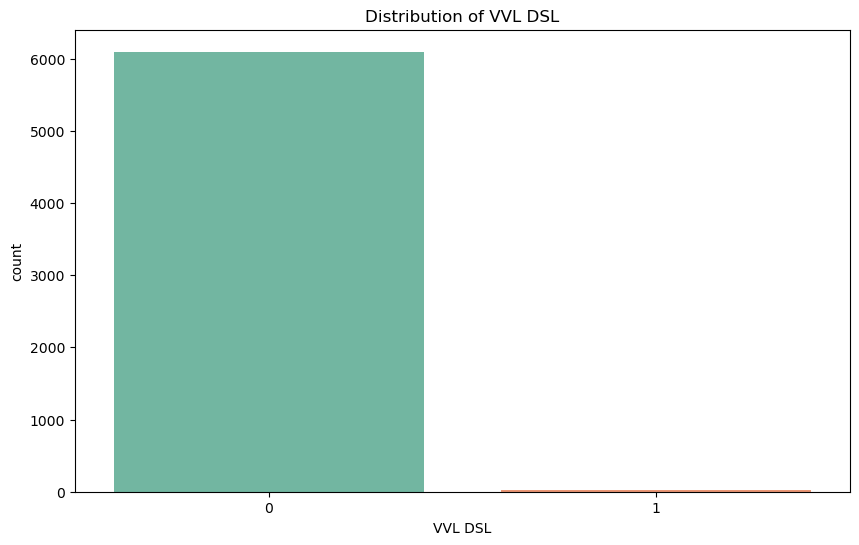

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


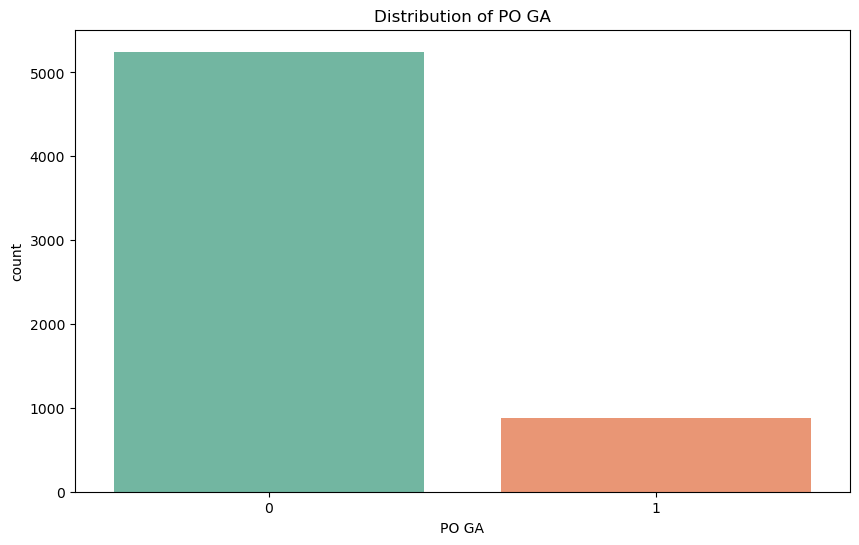

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


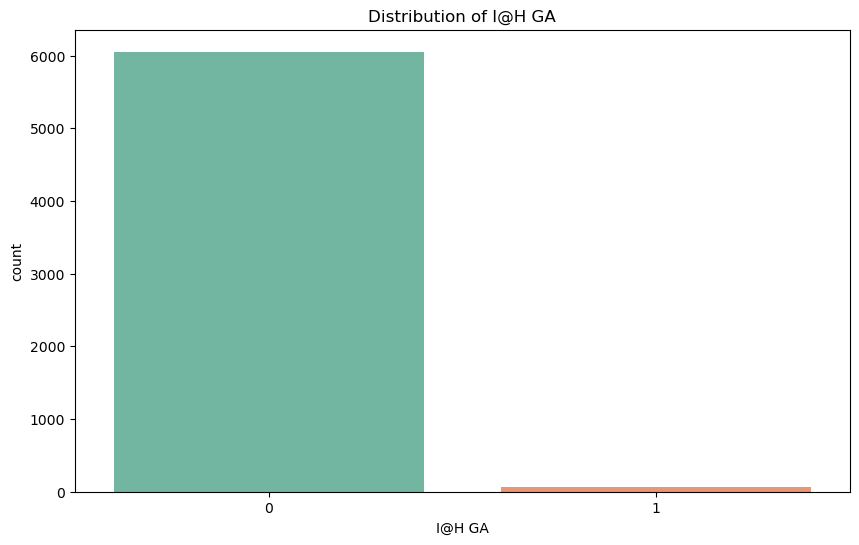

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\palettes.py:443: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(name)


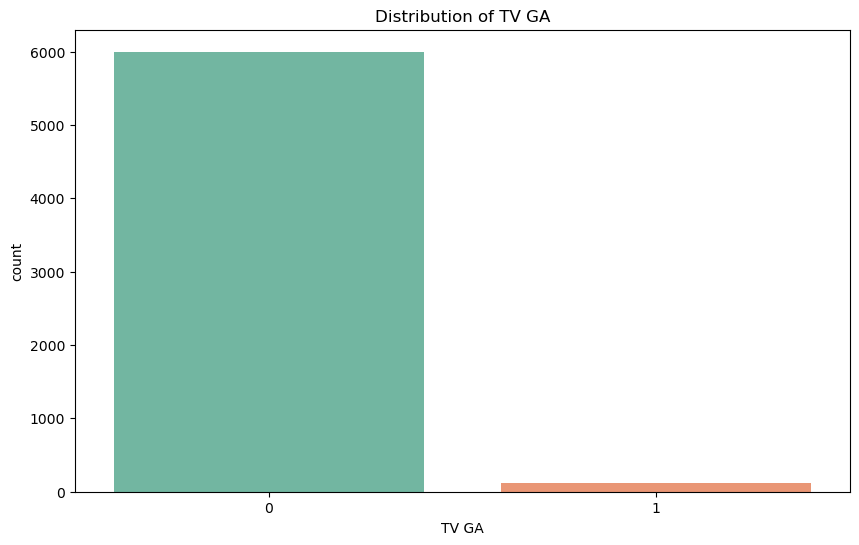

In [209]:
# Visualize the distribution of categorical variables
categorical_columns = ['VVL Mobile', 'VVL DSL', 'PO GA', 'I@H GA', 'TV GA']
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.show()

# Topic Modelling

In [156]:
# Tokenize the text and create a dictionary
def tokenize(text):
    return text.split()

texts_content = [tokenize(text) for text in df['text']]

# Create a dictionary from the tokenized text
dictionary_content = corpora.Dictionary(texts_content)

# Create document-term matrices
corpus_content = [dictionary_content.doc2bow(text) for text in texts_content]

# Perform LDA
num_topics =5
lda_model_content = gensim.models.LdaModel(corpus=corpus_content, id2word=dictionary_content, num_topics=num_topics)

# Print topics for the 'content' DataFrame
print("Topics for the text DataFrame:")
print(lda_model_content.print_topics(num_words=5))

Topics for the text DataFrame:
[(0, '0.021*"vertrag" + 0.016*"monat" + 0.014*"tarif" + 0.006*"beispiel" + 0.006*"rabatt"'), (1, '0.010*"storung" + 0.009*"versteh" + 0.008*"technik" + 0.007*"bewert" + 0.007*"internet"'), (2, '0.024*"rechnung" + 0.012*"handy" + 0.010*"vertrag" + 0.008*"kundennumm" + 0.007*"internet"'), (3, '0.023*"vertrag" + 0.016*"monat" + 0.013*"beispiel" + 0.012*"tarif" + 0.011*"handy"'), (4, '0.027*"vertrag" + 0.011*"adress" + 0.007*"wart" + 0.007*"weit" + 0.007*"auftrag"')]


In [157]:
# Evaluation
coherence_model_content = CoherenceModel(model=lda_model_content, texts=texts_content, dictionary=dictionary_content, coherence='c_v')
coherence_content = coherence_model_content.get_coherence()
# Compute Perplexity a measure of how good the model is. lower the better.
print('\nContent Perplexity: ', lda_model_content.log_perplexity(corpus_content))  
# Compute Coherence Score for lda_model_content
print('\nContent Coherence Score: ', coherence_content)


Content Perplexity:  -7.396375770781102

Content Coherence Score:  0.3281546834052225


C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


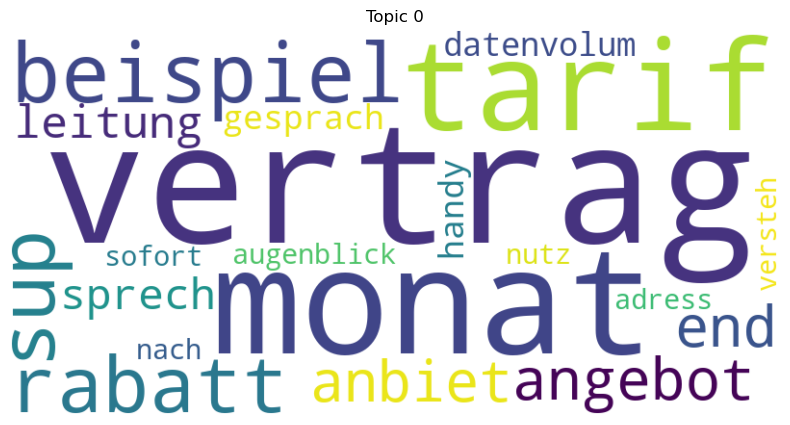

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


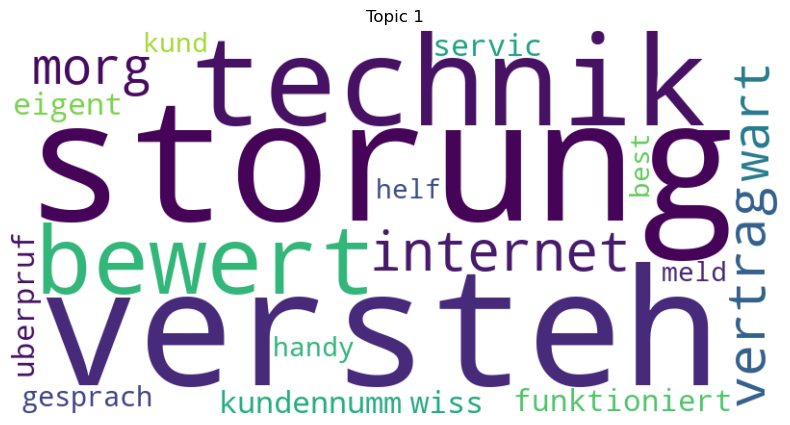

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


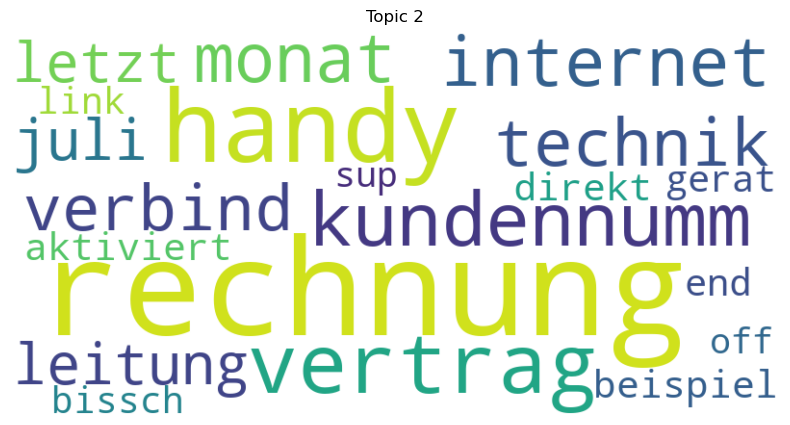

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


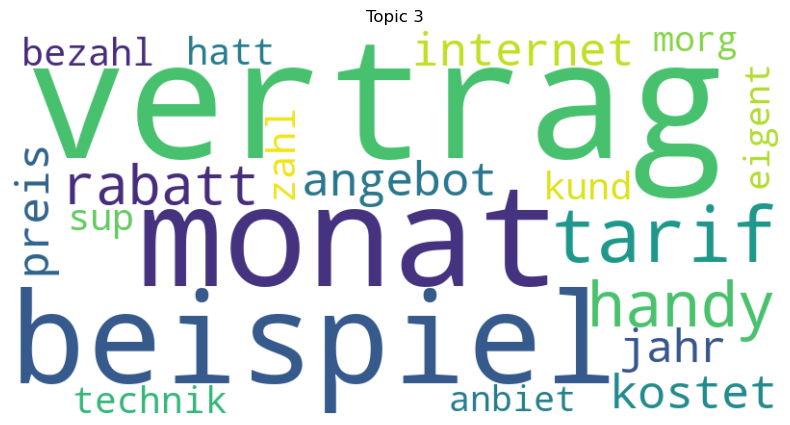

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


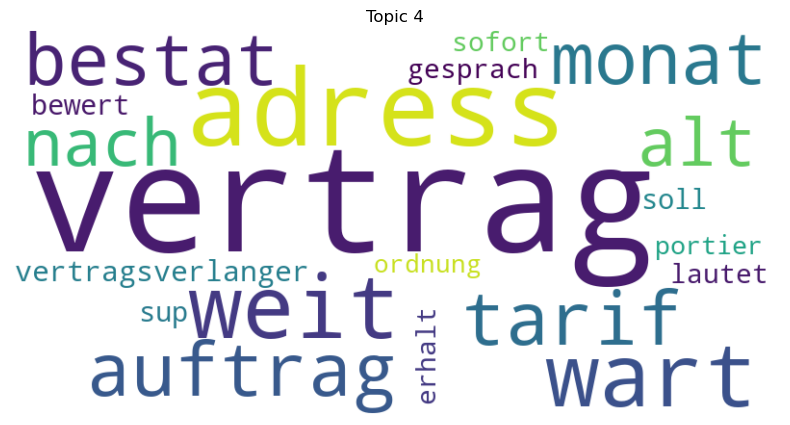

In [158]:
# Create a function to generate and display word clouds for each topic
def generate_word_clouds(lda_model, num_topics):
    for topic_num in range(num_topics):
        words = lda_model.show_topic(topic_num, topn=20)  # Get the top 20 words for each topic
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(words))
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Topic {topic_num}")
        plt.axis("off")
        plt.show()

# Assuming you have already defined lda_model_content and num_topics
generate_word_clouds(lda_model_content, num_topics)


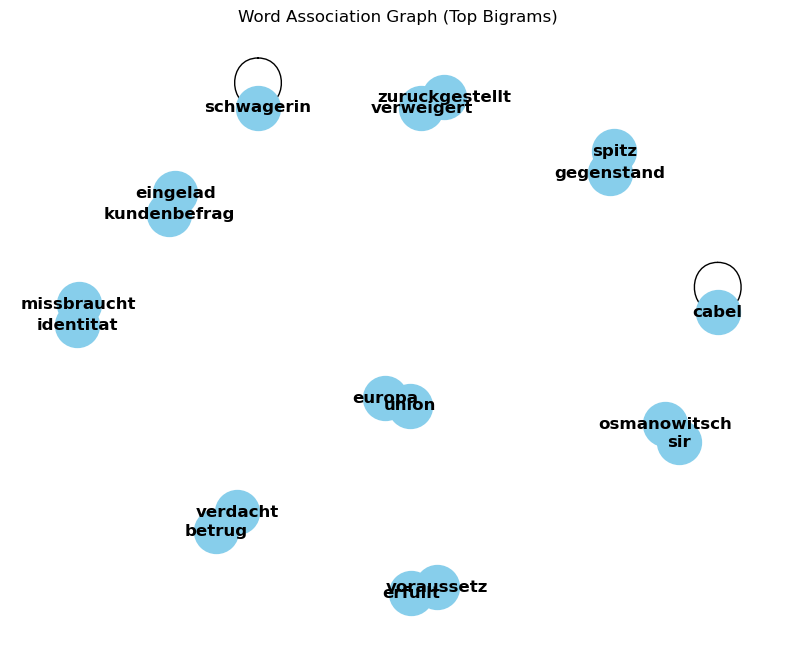

In [159]:
# Assuming you have a list of tokenized texts stored in 'texts_content'
# Join the tokens back into sentences
sentences = [' '.join(tokens) for tokens in texts_content]

# Tokenize the sentences again (if needed)
tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences]

# Create a BigramCollocationFinder
finder = BigramCollocationFinder.from_documents(tokenized_sentences)

# Set the association measure (you can adjust this)
bigram_measures = BigramAssocMeasures()
finder.apply_freq_filter(5)  # Adjust the frequency filter as needed

# Get the top bigrams
top_bigrams = finder.nbest(bigram_measures.pmi, 10)  # You can change the number of top bigrams

# Create a graph to represent word associations
G = nx.Graph()

# Add nodes and edges for the bigrams
for bigram in top_bigrams:
    word1, word2 = bigram
    G.add_node(word1)
    G.add_node(word2)
    G.add_edge(word1, word2)

# Create a figure and axis explicitly
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Define layout for the nodes
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, font_size=12, node_size=1000, node_color='skyblue', font_color='black', font_weight='bold', ax=ax)
plt.title("Word Association Graph (Top Bigrams)")
plt.show()


# Building supervised learning model for classify sales

In [161]:
# List of columns to encode
columns_to_encode = ['VVL Mobile', 'VVL DSL', 'PO GA', 'I@H GA', 'TV GA']

# Map True/False to 1/0 in the specified columns
df[columns_to_encode] = df[columns_to_encode].astype(int)

# Display the DataFrame after encoding
df


content  VVL Mobile  VVL DSL  \
0     Herzlich willkommen beim O Kundenservice mein ...           0        0   
1     Guten Morgen bei O sie sprechen mit Alexandra ...           0        0   
2     Ackermann fertig willkommen bei O sie sprechen...           0        0   
3     Herzlich willkommen im O Service mein Name ist...           0        0   
4     Guten Morgen herzlich willkommen bei O sie spr...           0        0   
...                                                 ...         ...      ...   
6117  Ja hallo schönen guten Tag herzlich willkommen...           0        0   
6118  Schönen guten tag Reiner Mohammad von O Kunden...           0        0   
6119  Herzlich kommen wir mal ausgeseien Service Tel...           0        0   
6120  O Kundenservice mein Name was darf ich für Sie...           0        0   
6121  Willkommen im Service sie sprechen mit sagen w...           0        0   

      PO GA  I@H GA  TV GA                                               text  \
0         0       0      0  beim kundenservic perfekt funfzig leitung gebu...   
1         1       0      0  morg sprech helf angegeb vertragsinhab wart mu...   
2         0       0      0  fertig sprech handy abgeschloss vertrag buchst...   
3         0       0      0  servic blind planung irgendwann faruk myhom ir...   
4         1       0      0  morg sprech valeri verschenk internet pruf kra...   
...     ...     ...    ...                                                ...   
6117      0       0      0  auto tarif berat sohn alt portiert termin fest...   
6118      0       0      0  heiss mittwoch nachnam lautet sich erhalt soll...   
6119      0       0      0  komm ausgesei servic euro dauert sich lauft ko...   
6120      0       0      0  schnell vollstand gehabt umzug durchfuhr zusam...   
6121      0       0      0  servic sprech datenabgleich nenn fix angekomm ...   

      word_count  
0            470  
1             14  
2            115  
3             57  
4            101  
...          ...  
6117          93  
6118         112  
6119         151  
6120         320  
6121          61  

[6122 rows x 8 columns]

# Train-Test Split

In [167]:
features = ['text']
targets = ['VVL Mobile', 'VVL DSL', 'PO GA','I@H GA', 'TV GA']
X_train, X_test = train_test_split(df[features + targets], test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

4897 1225


# Create word vectorization (Bag of Words with TfidVectorizer)

In [168]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(X_train["text"])
test_vectors = vectorizer.transform(X_test["text"])
print(train_vectors.shape, test_vectors.shape)

(4897, 13879) (1225, 13879)


# Complement Naive Bayes

In [169]:
# Define hyperparameter grid
alpha_range = loguniform(1e-2,1e1)
parameter_grid = {'alpha':alpha_range, 'norm':[True, False]}
randomsearch_CNB = ComplementNB()
randomsearch_clf = RandomizedSearchCV(randomsearch_CNB, parameter_grid,cv=10,scoring = "roc_auc", n_iter=50)

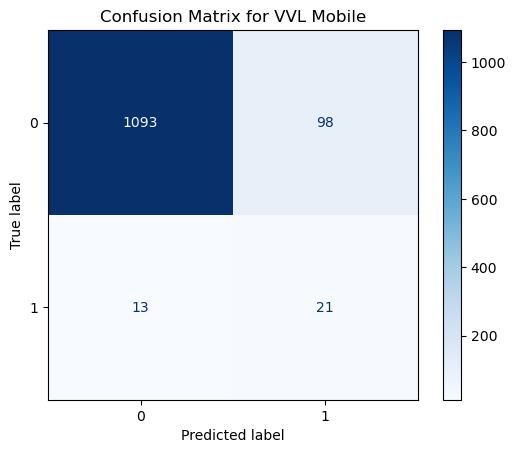

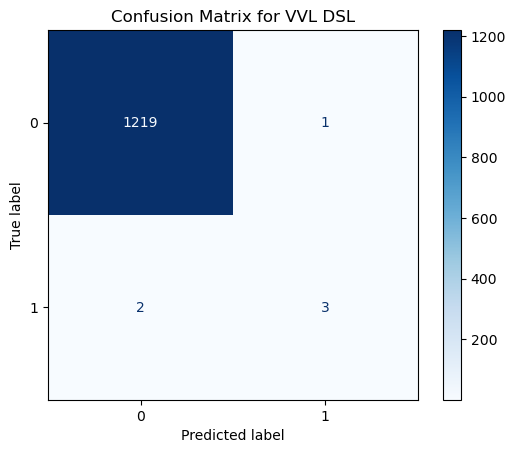

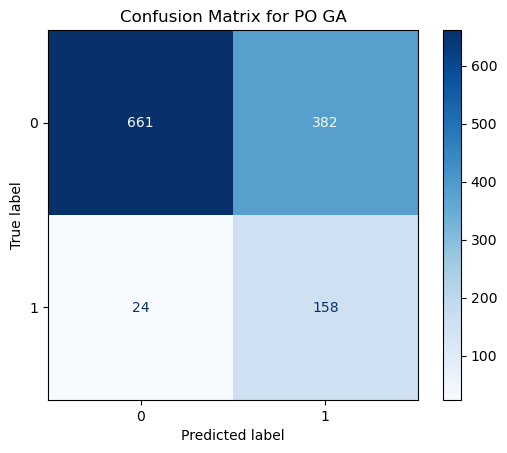

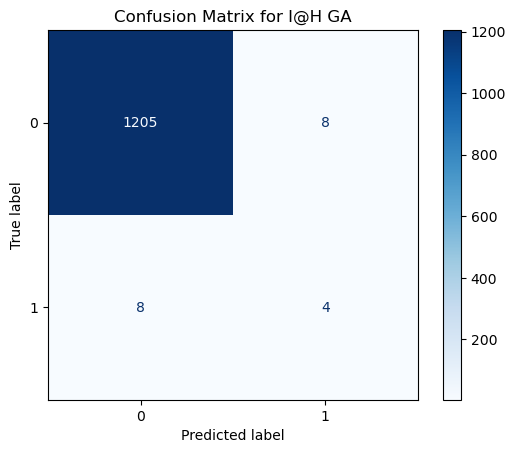

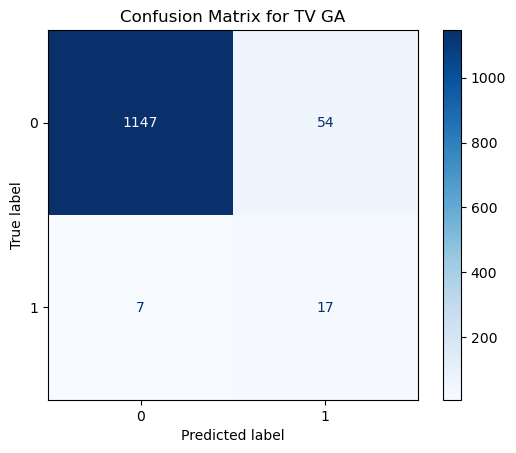

In [171]:
# Initialize an empty dataframe to store results
df_res = pd.DataFrame()

for target_id in range(len(targets)):
    randomsearch_clf.fit(train_vectors, X_train[targets[target_id]])

    # Get predictions on the test set
    predictions = randomsearch_clf.best_estimator_.predict(test_vectors)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(X_test[targets[target_id]], predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["0", "1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {targets[target_id]}')
    plt.show()

    # the code for classification report and accuracy calculation
    class_rep = classification_report(predictions, X_test[targets[target_id]], output_dict=True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    # Add target and model information to the dataframe
    res["target"] = targets[target_id]
    res["model"] = "ComplementNB"

    # Concatenate the results to the main dataframe
    df_res = pd.concat((df_res, res), ignore_index=True)


In [172]:

df_res.to_excel("model result.xlsx", index=False)

# GaussianNB

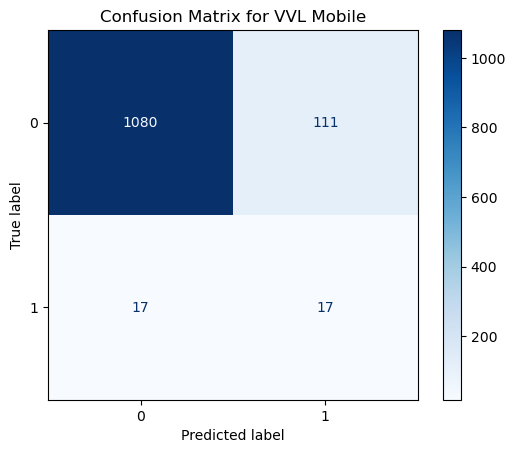

VVL Mobile


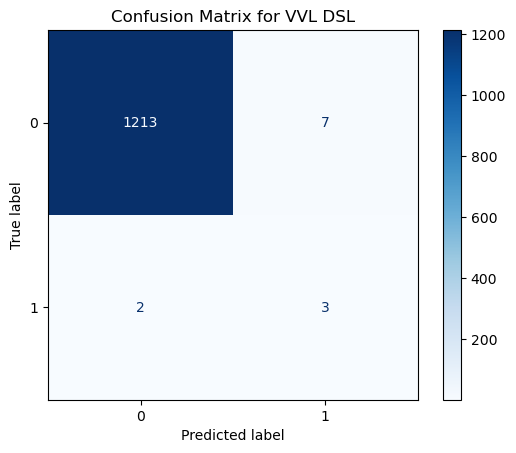

VVL DSL


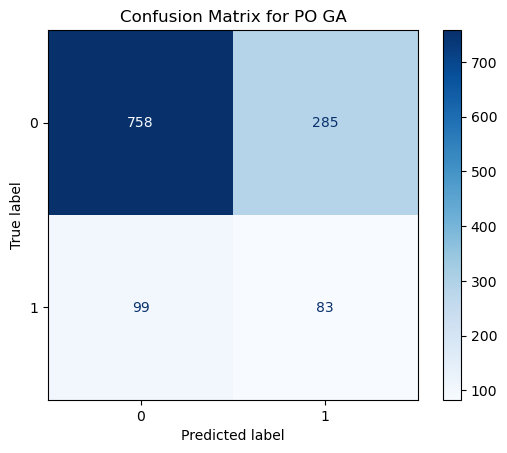

PO GA


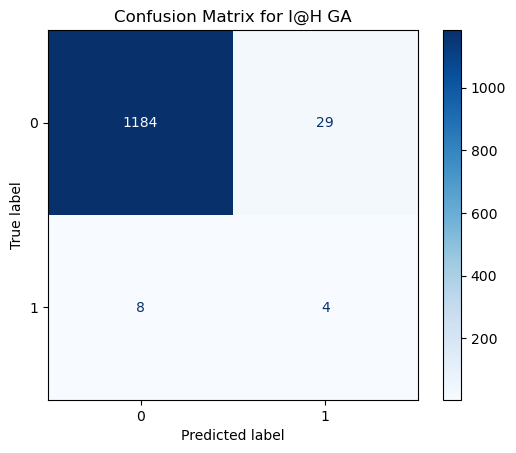

I@H GA


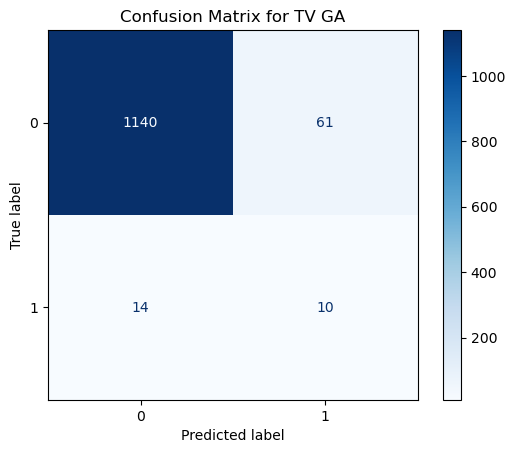

TV GA


In [173]:
for target_id in range(len(targets)):
    # no HP for GNB
    NBC = GaussianNB()
    NBC.fit(train_vectors.toarray(),X_train[targets[target_id]])
    # Get predictions on the test set
    predictions = NBC.predict(test_vectors.toarray())

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(X_test[targets[target_id]], predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["0", "1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {targets[target_id]}')
    plt.show()
    class_rep = classification_report(predictions,X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    res["model"] = "GaussianNaiveBayes"
    df_res = pd.concat((df_res,res), ignore_index=True)

In [174]:

df_res.to_excel("model result.xlsx", index=False)

# SVC

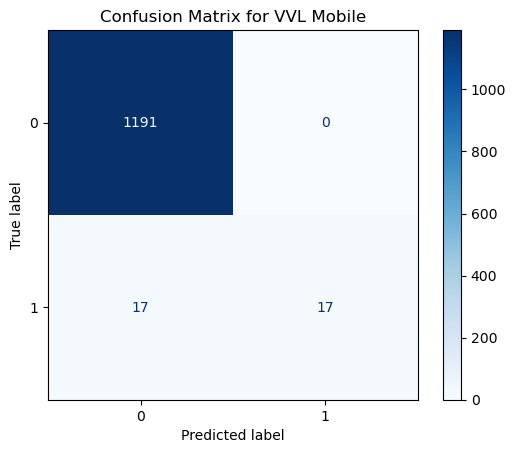

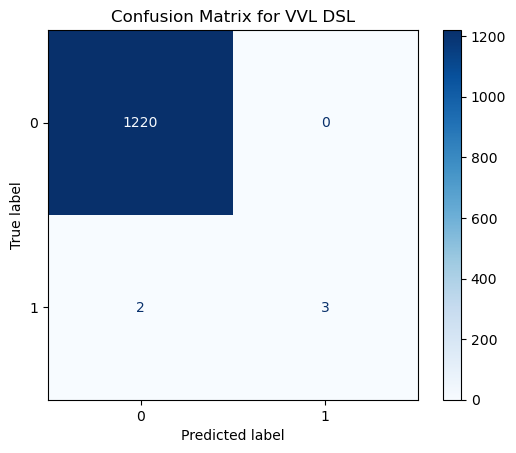

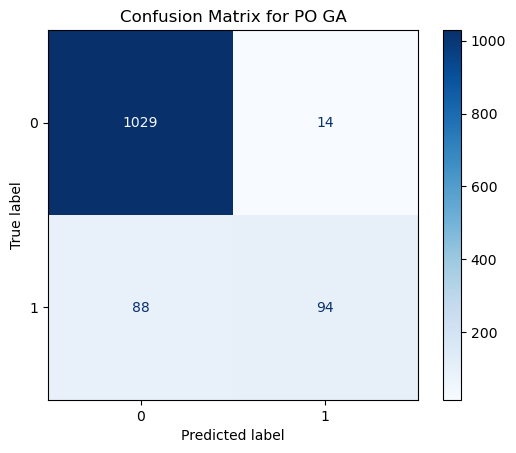

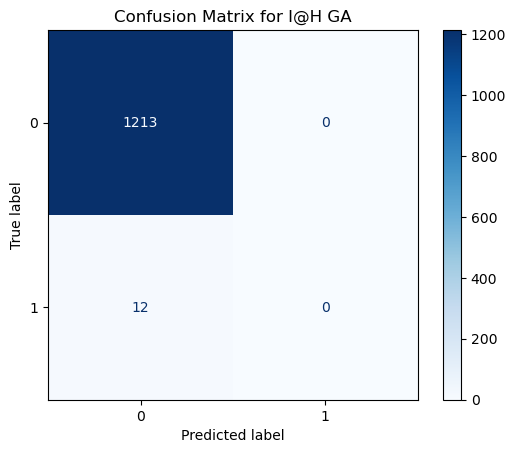

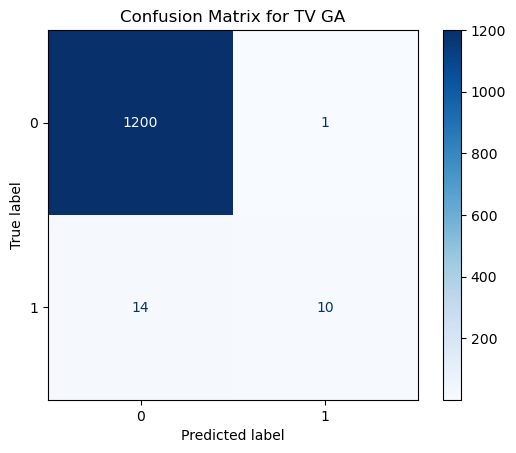

In [175]:
# Train all targets independently from one another
# and store relevant results in data frame for later comparison
c_range = loguniform(1e-1, 1e2)
degree_range = np.arange(1, 5, 1)
parameter_grid = {'C': c_range,
                  "kernel": ["linear", "poly", "rbf", "sigmoid"],
                  "degree": degree_range,
                  "gamma": ["scale", "auto"],
                  "decision_function_shape": ['ovo', 'ovr']}

randomsearch_SVC = SVC(probability=True)
randomsearch_clf_SVC = RandomizedSearchCV(randomsearch_SVC, parameter_grid, cv=10, scoring="roc_auc", n_iter=50)

for target_id in range(len(targets)):
    randomsearch_clf_SVC.fit(train_vectors, X_train[targets[target_id]])

    # Describe the problem in the FOCAL CELL
    # The error indicates that 'RandomizedSearchCV' object has no attribute 'best_estimator_'

    try:
        # Get predictions on the test set
        predictions = randomsearch_clf_SVC.best_estimator_.predict(test_vectors)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(X_test[targets[target_id]], predictions)

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["0", "1"])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {targets[target_id]}')
        plt.show()
        class_rep = classification_report(predictions,
                                           X_test[targets[target_id]], output_dict=True)
        res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
        res.rename({"index": "metric"}, axis=1, inplace=True)
        new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
        new_row.columns = res.columns
        res = pd.concat((res, new_row), ignore_index=True)

        res["target"] = targets[target_id]
        res["model"] = "SVC"
        df_res = pd.concat((df_res, res), ignore_index=True)

    except AttributeError as e:
        # Explain why the code is not working and how to fix it
        # 'RandomizedSearchCV' object has no attribute 'best_estimator_'
        # The RandomizedSearchCV object doesn't have a 'best_estimator_' attribute directly.
        # Use 'best_params_' to get the parameters of the best estimator found during the search.

        print(f"AttributeError: {e}")
        print("To fix this issue, replace 'randomsearch_clf_SVC.best_estimator_' with 'randomsearch_clf_SVC.best_params_'")


        # End the loop if an error occurs
        break

In [119]:
df_res.to_excel("model result.xlsx", index=False)

# RandomForestClassifier

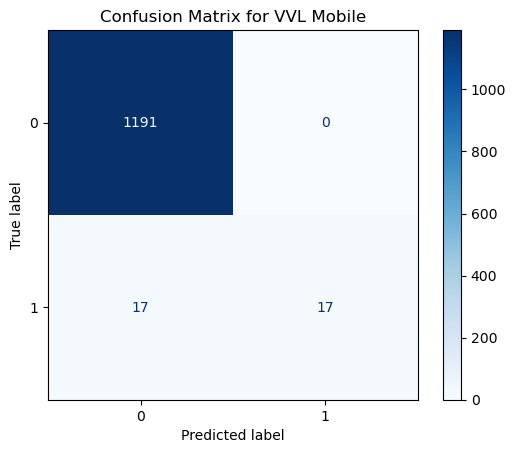

VVL Mobile
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 101, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


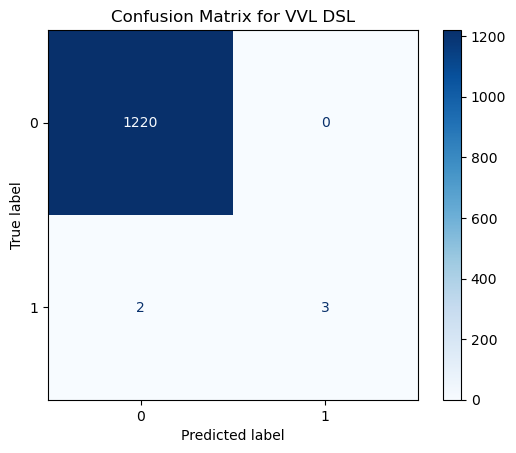

VVL DSL
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 182, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


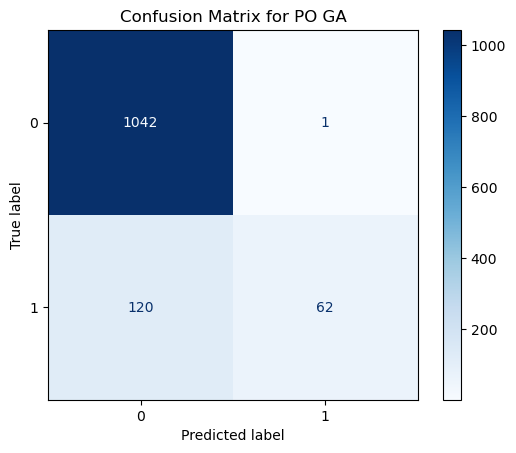

PO GA
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 146, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


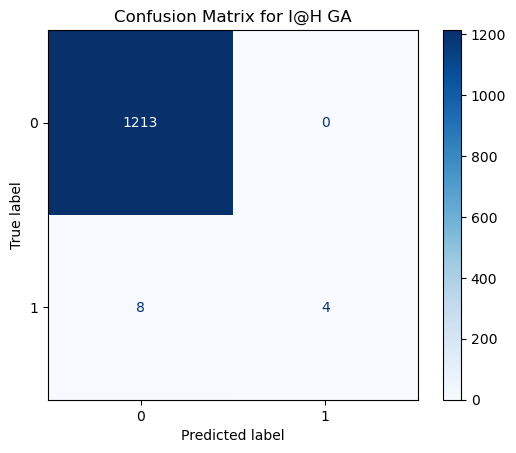

I@H GA
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 143, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


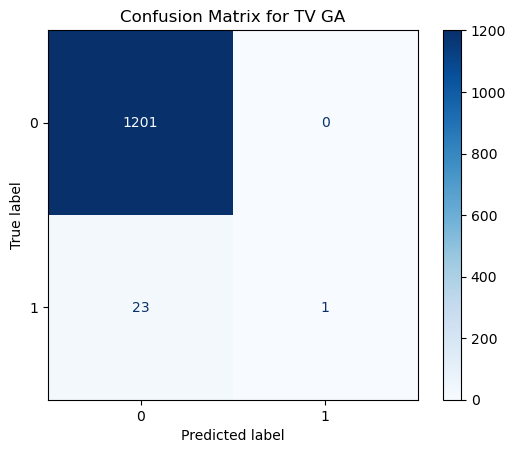

TV GA
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 130, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [176]:
parameter_grid = {"n_estimators": np.arange(80, 200, 1),
                  "min_samples_split": np.arange(2, 10, 1),
                  "min_samples_leaf": np.arange(1, 5, 1),
                  "criterion":["gini", "entropy", "log_loss"],
                  "class_weight":["balanced", "balanced_subsample",None],
                  }

randomsearch_RFC = RandomForestClassifier()
randomsearch_clf_RFC = RandomizedSearchCV(randomsearch_RFC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=100)

for target_id in range(len(targets)):
    randomsearch_clf_RFC.fit(train_vectors,X_train[targets[target_id]])
    # Get predictions on the test set
    predictions = randomsearch_clf_RFC.best_estimator_.predict(test_vectors)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(X_test[targets[target_id]], predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["0", "1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {targets[target_id]}')
    plt.show()
    class_rep = classification_report(predictions,X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf_RFC.best_estimator_.get_params())
    res["model"] = "RandomForest"
    df_res = pd.concat((df_res,res), ignore_index=True)

In [121]:
df_res.to_excel("model result.xlsx", index=False)


# AdaBoostClassifier

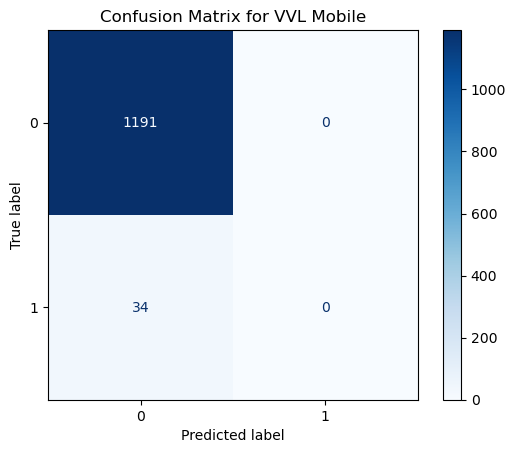

VVL Mobile
{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.10039575625828699, 'n_estimators': 37, 'random_state': None}


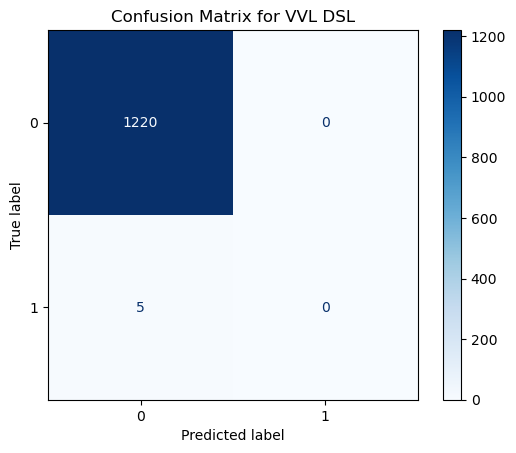

VVL DSL
{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.1874269983165351, 'n_estimators': 39, 'random_state': None}


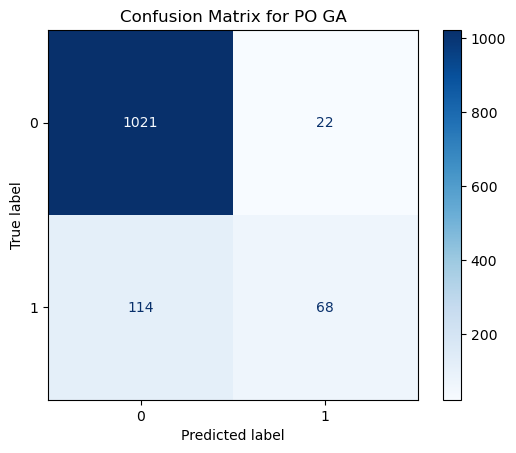

PO GA
{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.3264283611361978, 'n_estimators': 76, 'random_state': None}


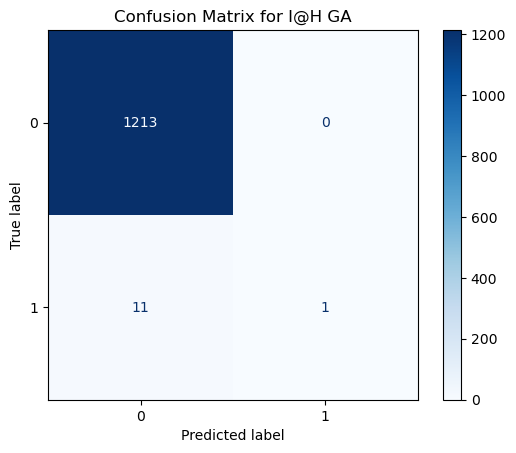

I@H GA
{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.13794813280763094, 'n_estimators': 36, 'random_state': None}


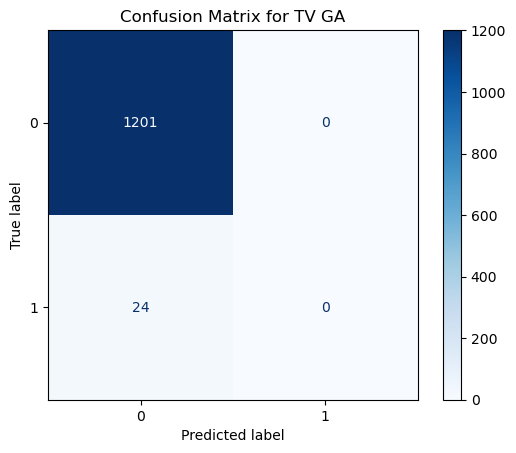

TV GA
{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 0.13594945084021076, 'n_estimators': 46, 'random_state': None}


In [177]:
parameter_grid = {"n_estimators": np.arange(30, 100, 1),
                  "learning_rate": loguniform(1e-1, 1e1)
                  }

randomsearch_ABC = AdaBoostClassifier()
randomsearch_clf_ABC = RandomizedSearchCV(randomsearch_ABC, parameter_grid,cv=10,scoring = "roc_auc", n_iter=20)

for target_id in range(len(targets)):
    randomsearch_clf_ABC.fit(train_vectors,X_train[targets[target_id]])
    # Get predictions on the test set
    predictions = randomsearch_clf_ABC.best_estimator_.predict(test_vectors)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(X_test[targets[target_id]], predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["0", "1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {targets[target_id]}')
    plt.show()
    class_rep = classification_report(predictions,X_test[targets[target_id]],output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf_ABC.best_estimator_.get_params())
    res["model"] = "AdaBoost"
    df_res = pd.concat((df_res,res), ignore_index=True)

In [123]:
df_res.to_excel("model result.xlsx", index=False)

# GaussianProcessClassifier

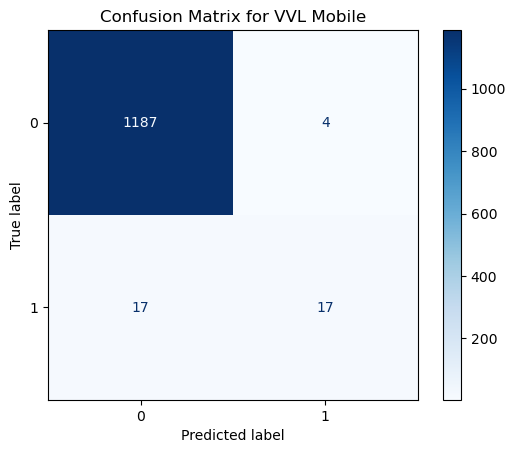

VVL Mobile
{'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1.15), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.15, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1.15), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}


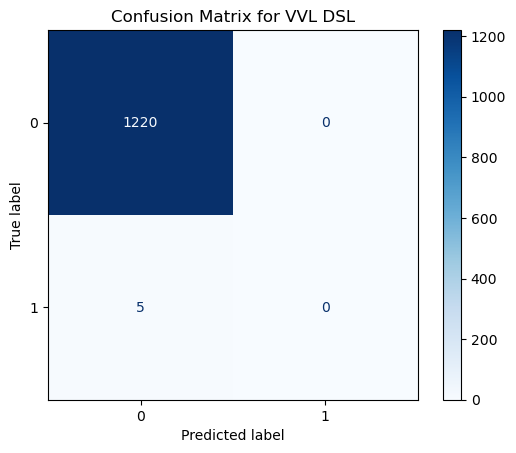

VVL DSL
{'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1.15), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.15, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1.15), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}


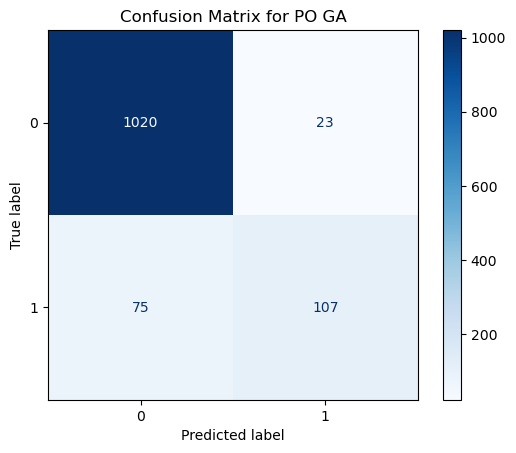

PO GA
{'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1.15), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.15, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1.15), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}


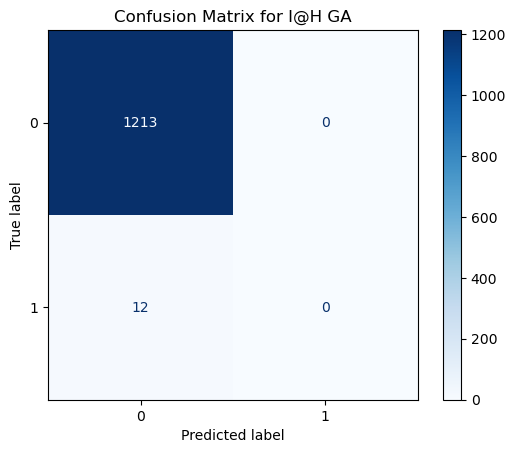

I@H GA
{'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1.15), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.15, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1.15), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}


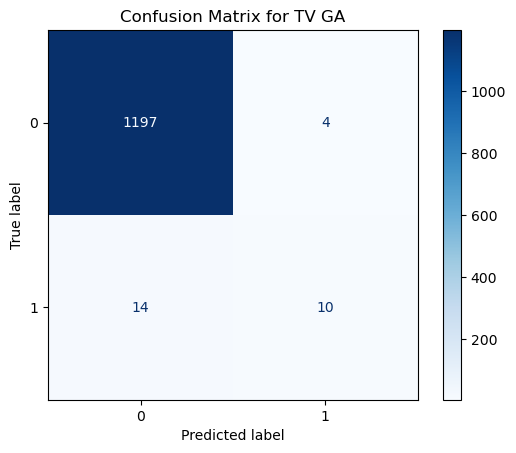

TV GA
{'copy_X_train': True, 'kernel__k1': 1**2, 'kernel__k2': RBF(length_scale=1.15), 'kernel__k1__constant_value': 1.0, 'kernel__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__length_scale': 1.15, 'kernel__k2__length_scale_bounds': (1e-05, 100000.0), 'kernel': 1**2 * RBF(length_scale=1.15), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': None, 'n_restarts_optimizer': 0, 'optimizer': 'fmin_l_bfgs_b', 'random_state': None, 'warm_start': False}


In [178]:
parameter_grid = {"kernel": [1.0 * RBF(length_scale=1.15), 1.0 * DotProduct(sigma_0=1.0) ** 2]}

# gridsearch since we're comparing exactly two settings
randomsearch_GPC = GaussianProcessClassifier()
randomsearch_clf_GPC = RandomizedSearchCV(randomsearch_GPC, parameter_grid,cv=2,scoring = "roc_auc")

for target_id in range(len(targets)):
    randomsearch_clf_GPC.fit(train_vectors.toarray(),np.array(X_train[targets[target_id]]))
    # Get predictions on the test set
    predictions = randomsearch_clf_GPC.best_estimator_.predict(test_vectors.toarray())

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(X_test[targets[target_id]], predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["0", "1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {targets[target_id]}')
    plt.show()
    class_rep = classification_report(predictions,np.array(X_test[targets[target_id]]),output_dict =True)
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(id_vars=("index"), var_name="subclass")
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf_GPC.best_estimator_.get_params())
    res["model"] = "GaussianProcess"
    df_res = pd.concat((df_res,res), ignore_index=True)

In [179]:
df_res.to_excel("model result.xlsx", index=False)

# KNeighborsClassifier

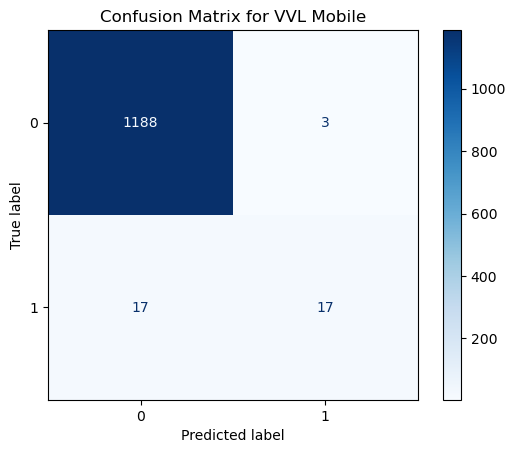

VVL Mobile
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


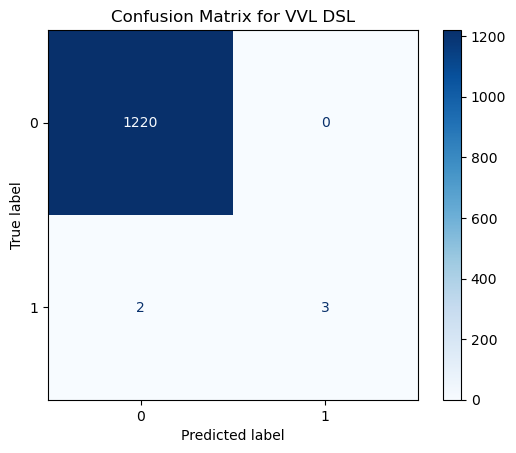

VVL DSL
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


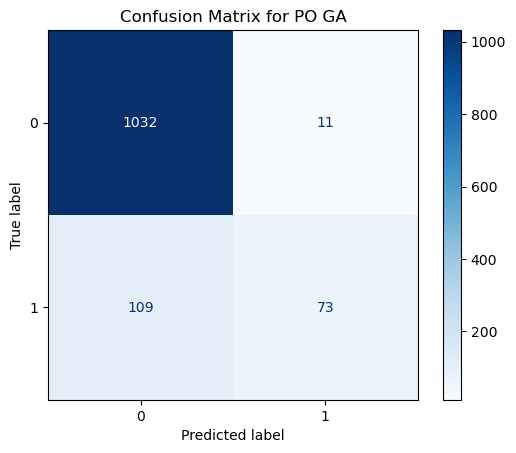

PO GA
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


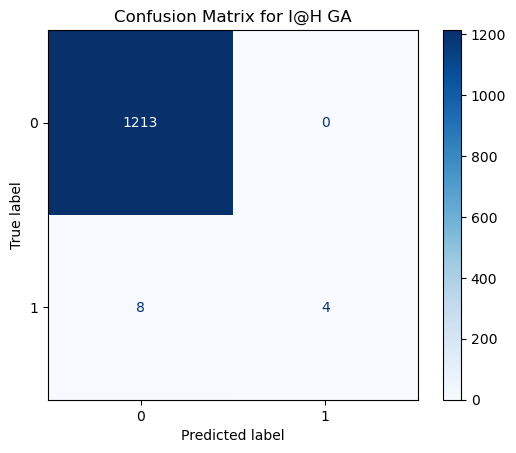

I@H GA
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


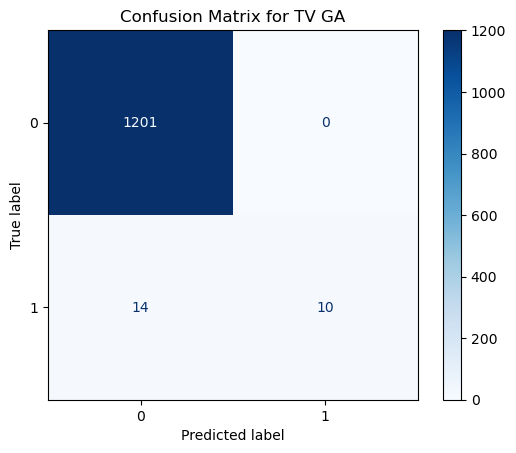

TV GA
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


In [180]:
parameter_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}

randomsearch_KNN = KNeighborsClassifier()
randomsearch_clf_KNN = RandomizedSearchCV(
    randomsearch_KNN, parameter_grid, cv=10, scoring="roc_auc", n_iter=100
)

for target_id in range(len(targets)):
    randomsearch_clf_KNN.fit(train_vectors, X_train[targets[target_id]])
    # Get predictions on the test set
    predictions = randomsearch_clf_KNN.best_estimator_.predict(test_vectors)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(X_test[targets[target_id]], predictions)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["0", "1"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {targets[target_id]}')
    plt.show()
    class_rep = classification_report(
        predictions,
        X_test[targets[target_id]],
        output_dict=True,
    )
    res = pd.DataFrame(class_rep)[["0", "1"]].reset_index().melt(
        id_vars=("index"), var_name="subclass"
    )
    res.rename({"index": "metric"}, axis=1, inplace=True)
    new_row = pd.DataFrame(["accuracy", None, class_rep["accuracy"]]).T
    new_row.columns = res.columns
    res = pd.concat((res, new_row), ignore_index=True)

    res["target"] = targets[target_id]
    print(targets[target_id])
    print(randomsearch_clf_KNN.best_estimator_.get_params())
    res["model"] = "KNeighborsClassifier"
    df_res = pd.concat((df_res, res), ignore_index=True)


In [181]:
df_res.to_excel("model result.xlsx", index=False)

# Evaluation

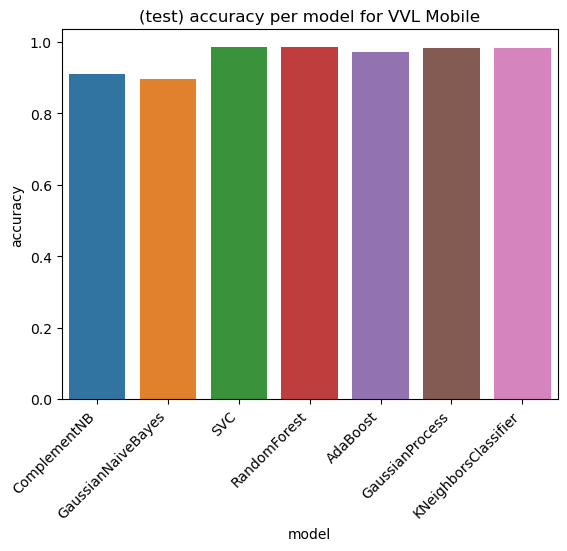

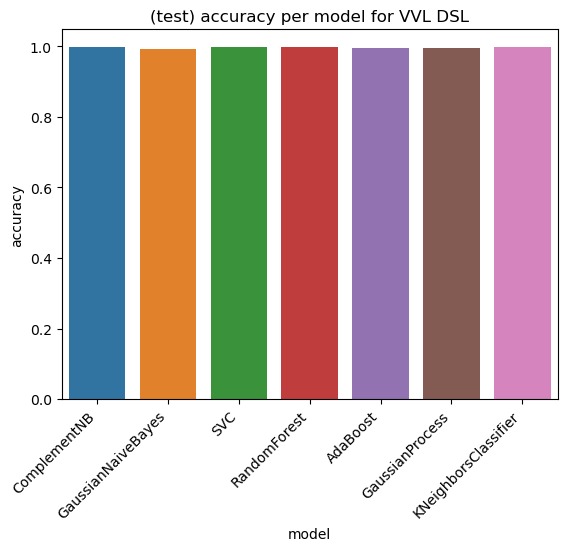

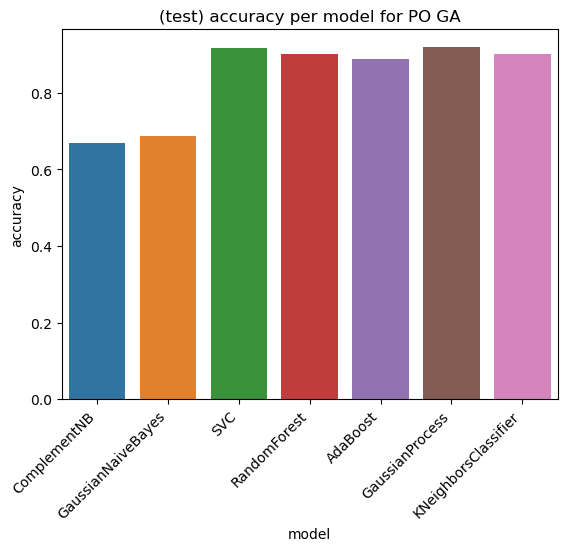

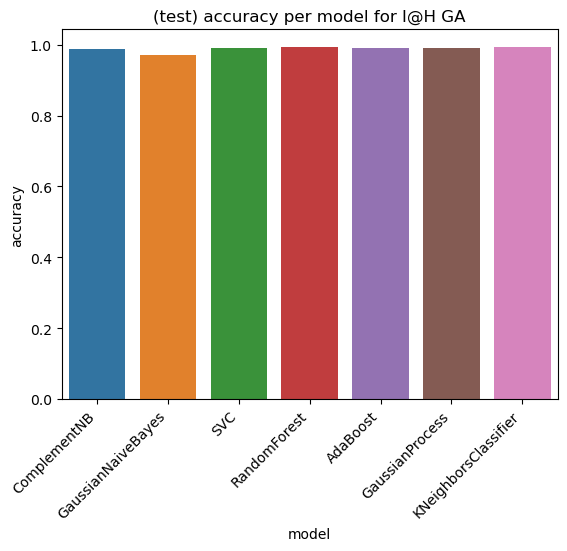

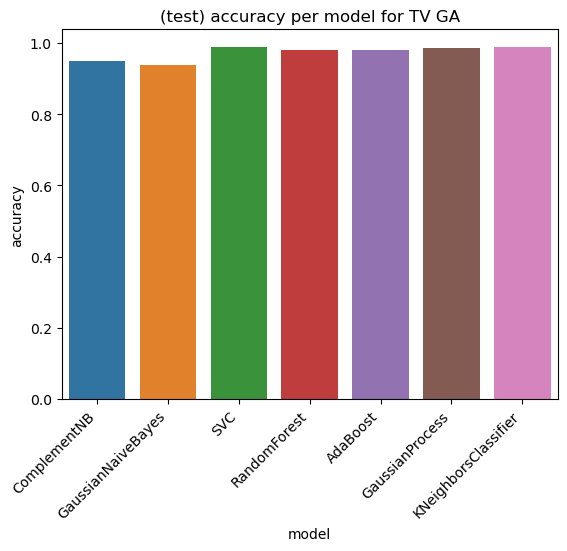

In [182]:
for variable in targets:
    # Filter the data based on conditions
    filtered_data = df_res.loc[(df_res["metric"] == "accuracy") & (df_res["target"] == variable)]

    # Check if there is data after filtering
    if not filtered_data.empty:
        # Create the bar plot
        ax = sns.barplot(data=filtered_data, x="model", y="value")

        # Set plot title and labels
        plt.title(f"(test) accuracy per model for {variable}")
        plt.ylabel("accuracy")

        # Rotate x-axis labels for better visibility
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

        # Show the plot
        plt.show()
    else:
        print(f"No data for {variable}")


C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


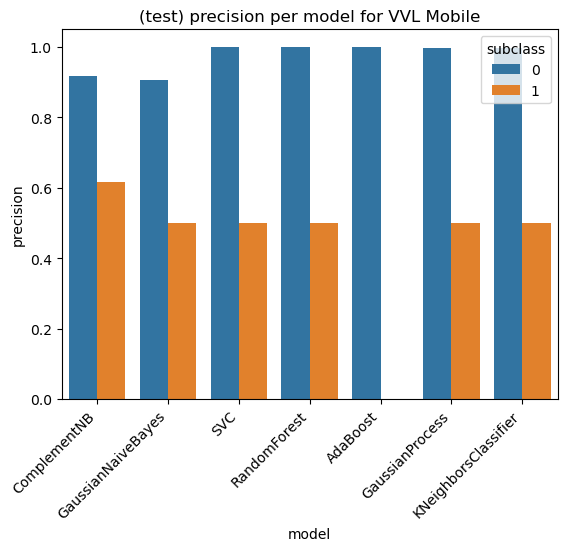

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


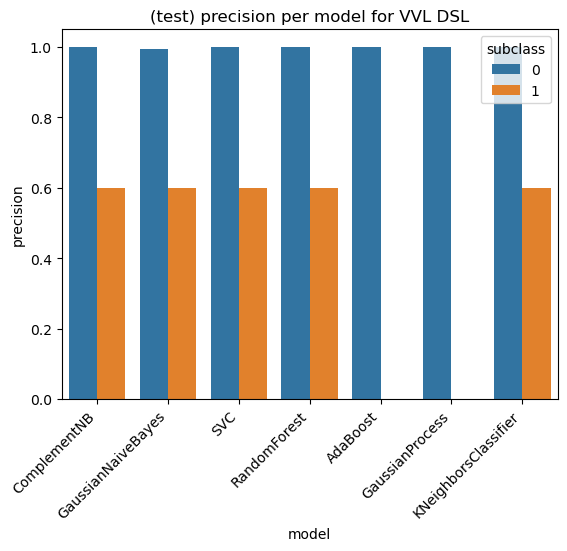

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


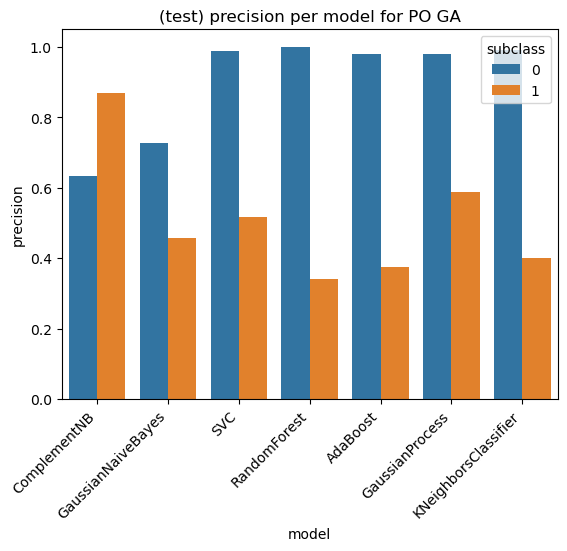

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


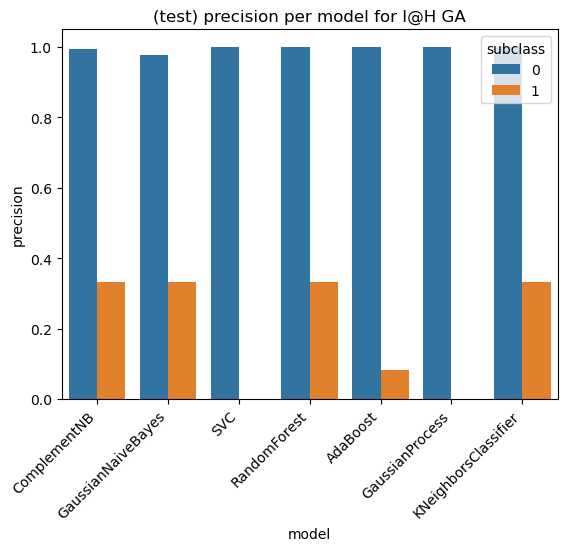

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


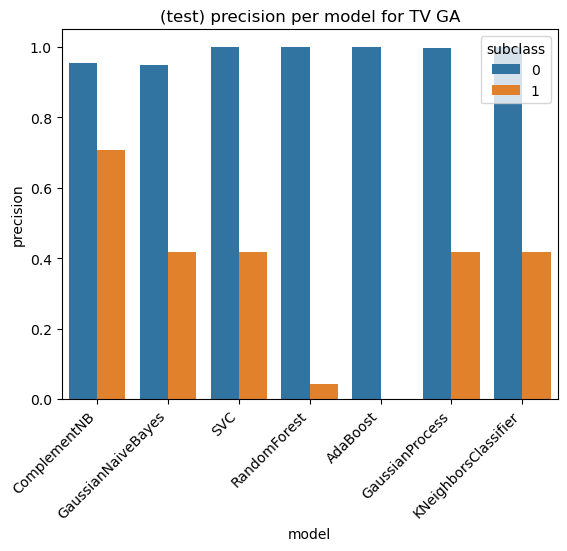

In [183]:
for variable in targets:
    # Filter the data based on conditions
    filtered_data = df_res.loc[(df_res["metric"] == "precision") & (df_res["target"] == variable)]

    # Check if there is data after filtering
    if not filtered_data.empty:
        # Create the bar plot
        ax = sns.barplot(data=filtered_data, x="model", y="value", hue="subclass")

        # Set plot title and labels
        plt.title(f"(test) precision per model for {variable}")
        plt.ylabel("precision")

        # Rotate x-axis labels for better visibility
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

        # Show the plot
        plt.show()
    else:
        print(f"No data for {variable}")    

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


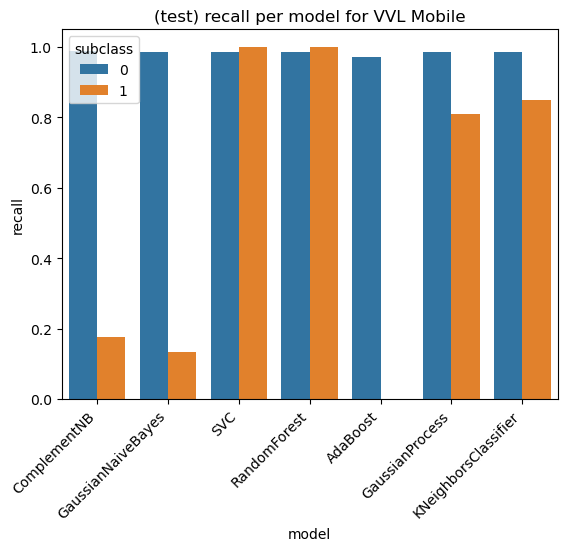

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


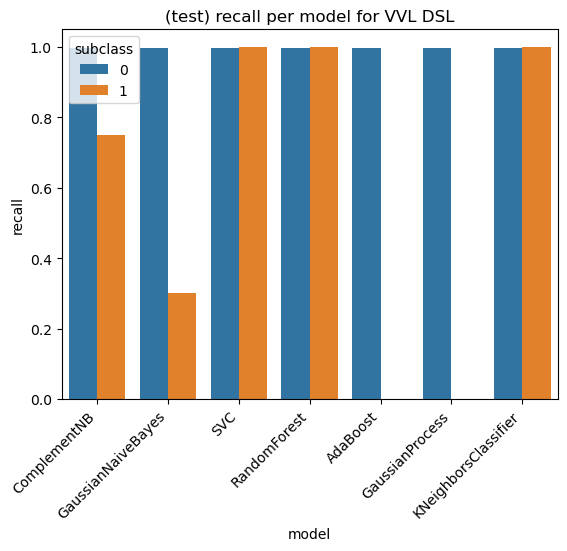

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


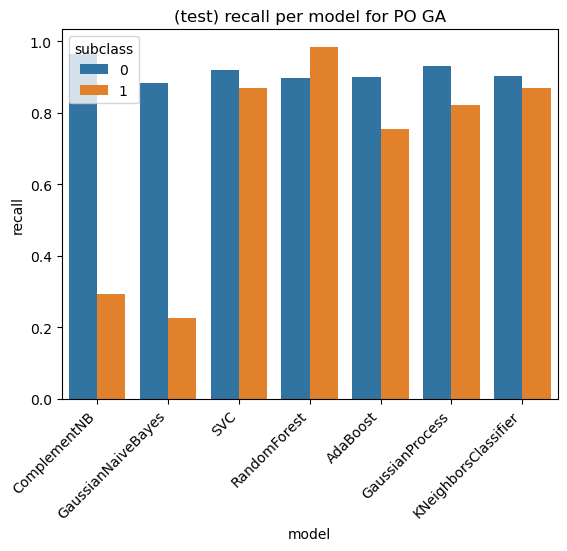

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


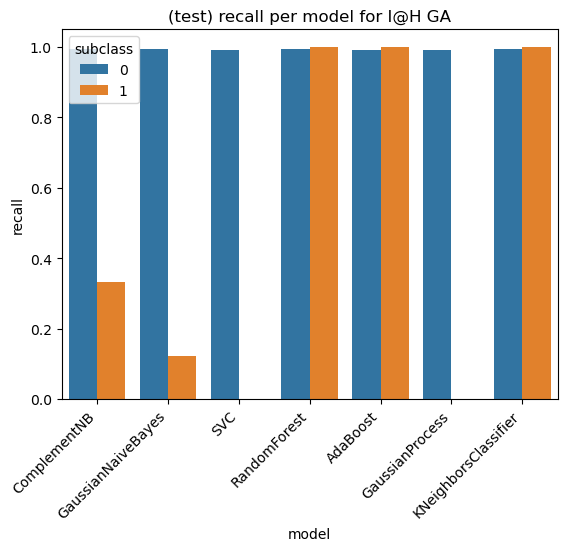

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


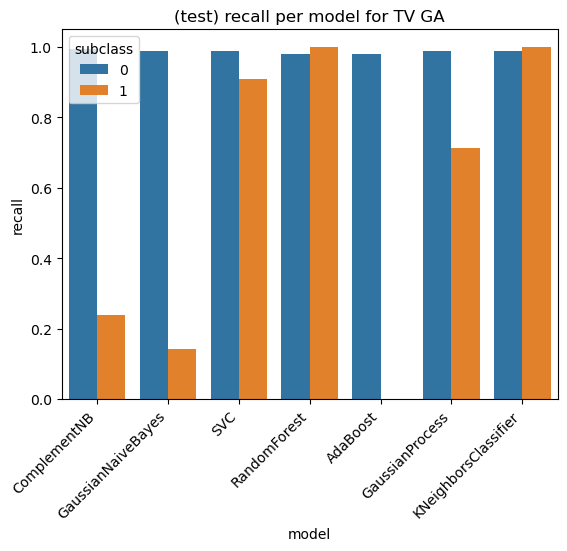

In [184]:
for variable in targets:
    # Filter the data based on conditions
    filtered_data = df_res.loc[(df_res["metric"] == "recall") & (df_res["target"] == variable)]

    # Check if there is data after filtering
    if not filtered_data.empty:
        # Create the bar plot
        ax = sns.barplot(data=filtered_data, x="model", y="value", hue="subclass")

        # Set plot title and labels
        plt.title(f"(test) recall per model for {variable}")
        plt.ylabel("recall")

        # Rotate x-axis labels for better visibility
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

        # Show the plot
        plt.show()
    else:
        print(f"No data for {variable}")    

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


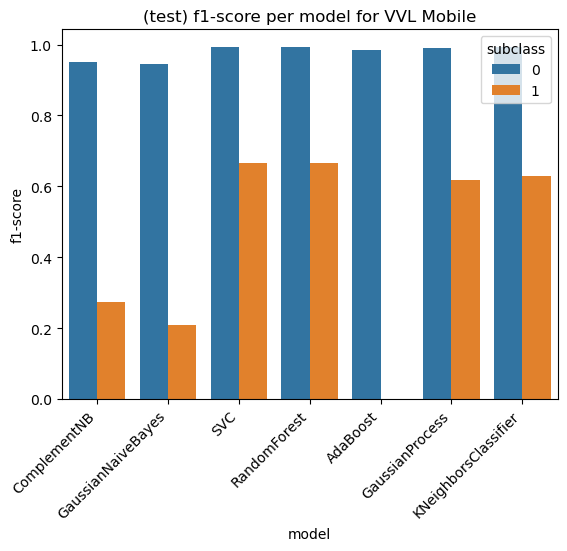

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


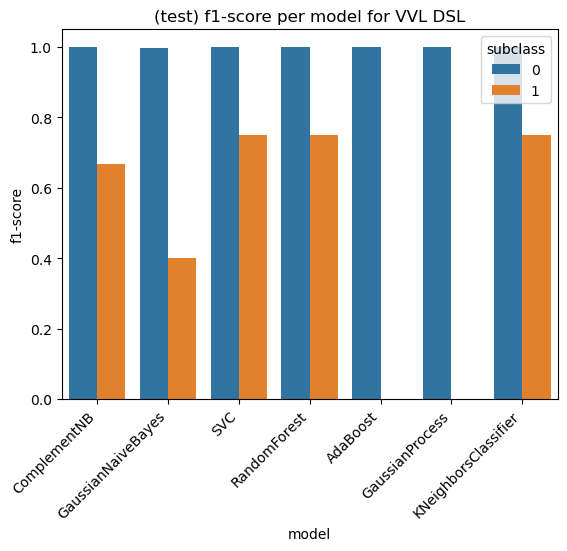

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


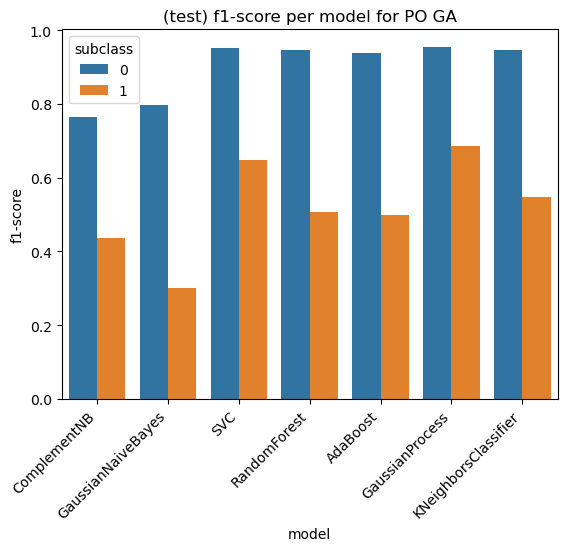

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


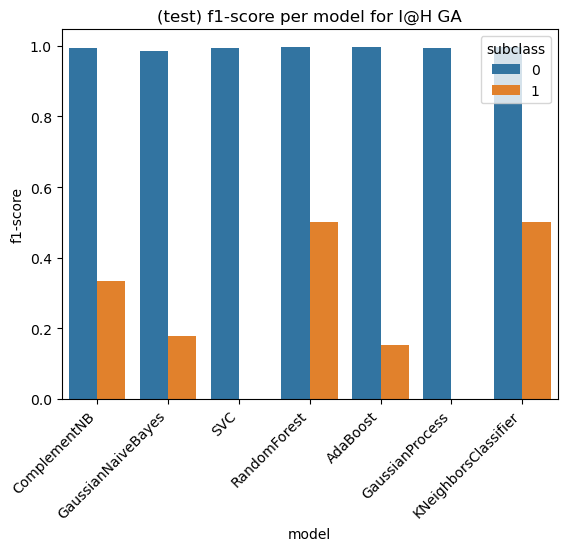

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


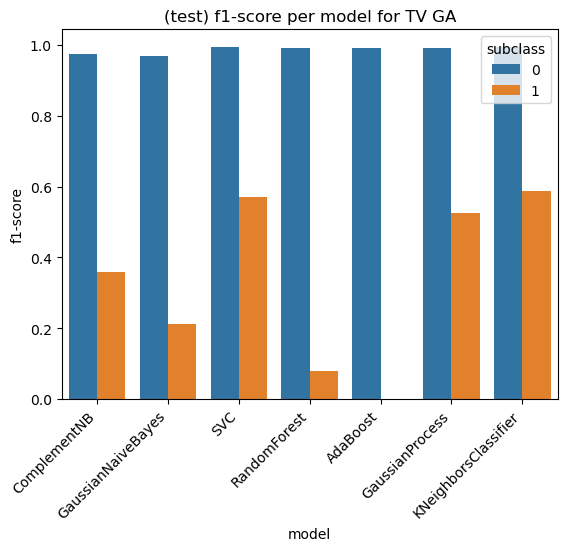

In [185]:
for variable in targets:
    # Filter the data based on conditions
    filtered_data = df_res.loc[(df_res["metric"] == "f1-score") & (df_res["target"] == variable)]

    # Check if there is data after filtering
    if not filtered_data.empty:
        # Create the bar plot
        ax = sns.barplot(data=filtered_data, x="model", y="value", hue="subclass")

        # Set plot title and labels
        plt.title(f"(test) f1-score per model for {variable}")
        plt.ylabel("f1-score")

        # Rotate x-axis labels for better visibility
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

        # Show the plot
        plt.show()
    else:
        print(f"No data for {variable}")   

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


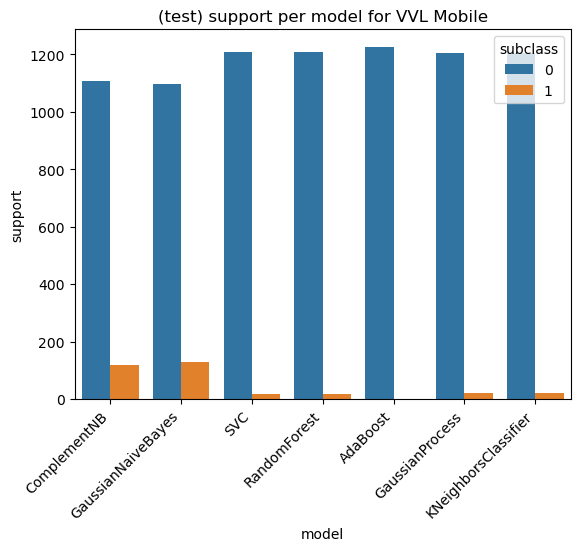

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


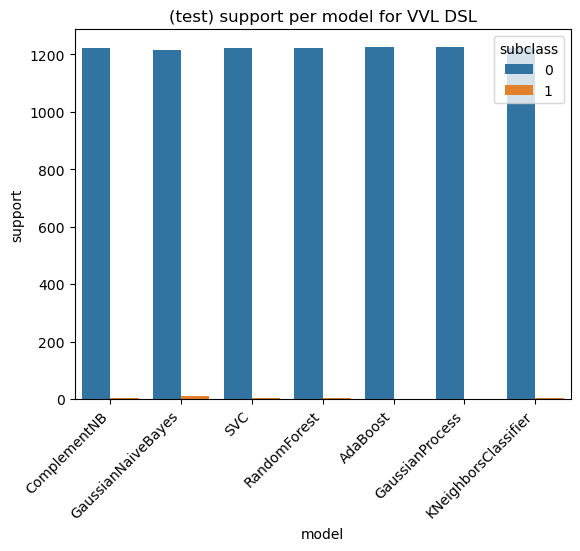

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


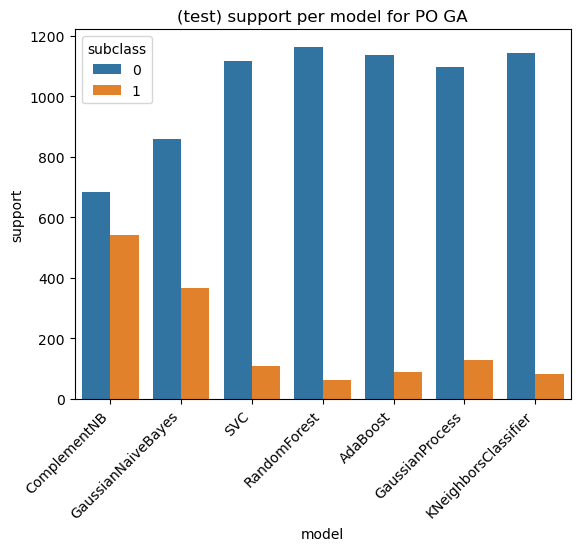

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


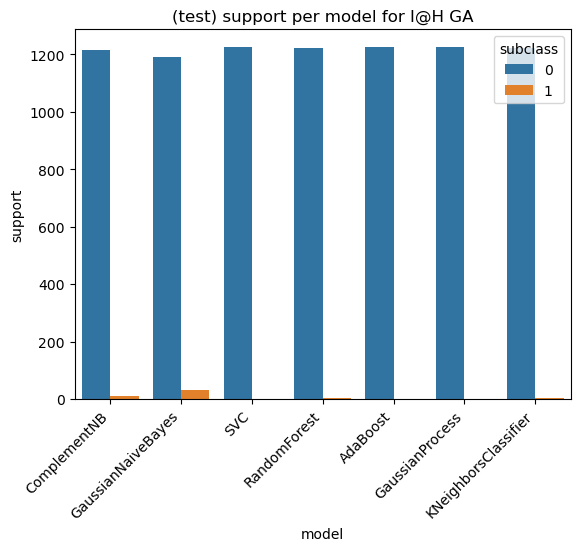

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


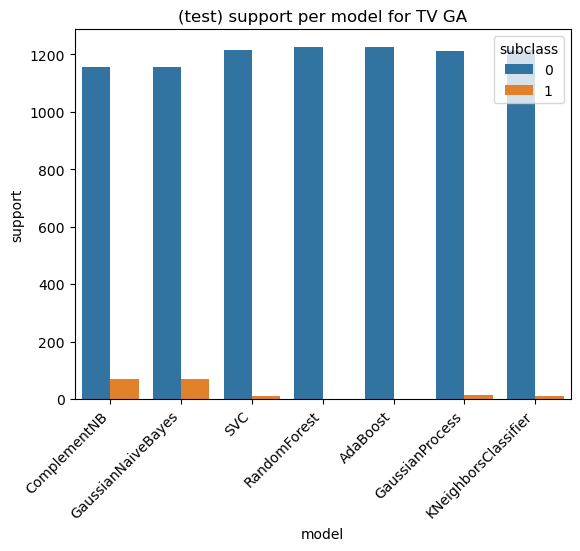

In [186]:
for variable in targets:
    # Filter the data based on conditions
    filtered_data = df_res.loc[(df_res["metric"] == "support") & (df_res["target"] == variable)]

    # Check if there is data after filtering
    if not filtered_data.empty:
        # Create the bar plot
        ax = sns.barplot(data=filtered_data, x="model", y="value", hue="subclass")

        # Set plot title and labels
        plt.title(f"(test) support per model for {variable}")
        plt.ylabel("support")

        # Rotate x-axis labels for better visibility
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

        # Show the plot
        plt.show()
    else:
        print(f"No data for {variable}")   

C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Muhammad Farhan\anaconda\Lib\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


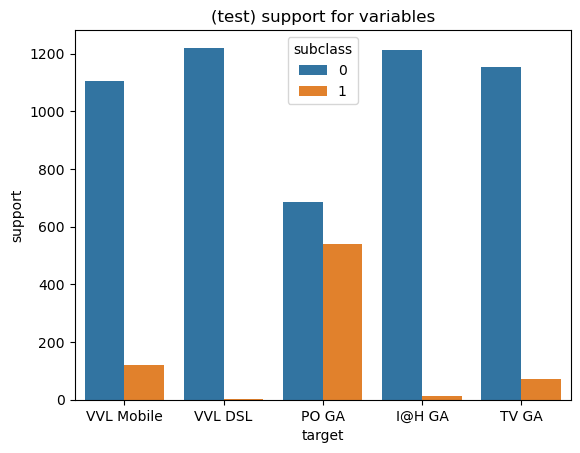

In [187]:
filtered_data = df_res.loc[(df_res["metric"]=="support") & (df_res["model"]=="ComplementNB")]
ax = sns.barplot(data=filtered_data, x="target", y="value", hue="subclass")
plt.title(f"(test) support for variables")
plt.ylabel("support")
plt.show()

In [188]:
df_res.to_excel("model result.xlsx", index=False)

# Sales percentage and another target variable

In [190]:
# Function to calculate percentage
def calculate_percentage(counts):
    total_count = counts.sum()
    percentage_0 = (counts[0] / total_count) * 100
    percentage_1 = (counts[1] / total_count) * 100
    return percentage_0, percentage_1

# Counts for each variable
counts_1 = df['VVL Mobile'].value_counts()
counts_2 = df['VVL DSL'].value_counts()
counts_3 = df['PO GA'].value_counts()
counts_4 = df['I@H GA'].value_counts()
counts_5 = df['TV GA'].value_counts()

# Calculate and print percentages for each variable
percentage_0, percentage_1 = calculate_percentage(counts_1)
print(f"VVL Mobile - Percentage of 0: {percentage_0:.2f}%, Percentage of 1: {percentage_1:.2f}%")

percentage_0, percentage_1 = calculate_percentage(counts_2)
print(f"VVL DSL - Percentage of 0: {percentage_0:.2f}%, Percentage of 1: {percentage_1:.2f}%")

percentage_0, percentage_1 = calculate_percentage(counts_3)
print(f"PO GA - Percentage of 0: {percentage_0:.2f}%, Percentage of 1: {percentage_1:.2f}%")

percentage_0, percentage_1 = calculate_percentage(counts_4)
print(f"I@H GA - Percentage of 0: {percentage_0:.2f}%, Percentage of 1: {percentage_1:.2f}%")

percentage_0, percentage_1 = calculate_percentage(counts_5)
print(f"TV GA - Percentage of 0: {percentage_0:.2f}%, Percentage of 1: {percentage_1:.2f}%")


VVL Mobile - Percentage of 0: 96.55%, Percentage of 1: 3.45%
VVL DSL - Percentage of 0: 99.58%, Percentage of 1: 0.42%
PO GA - Percentage of 0: 85.71%, Percentage of 1: 14.29%
I@H GA - Percentage of 0: 98.91%, Percentage of 1: 1.09%
TV GA - Percentage of 0: 98.01%, Percentage of 1: 1.99%


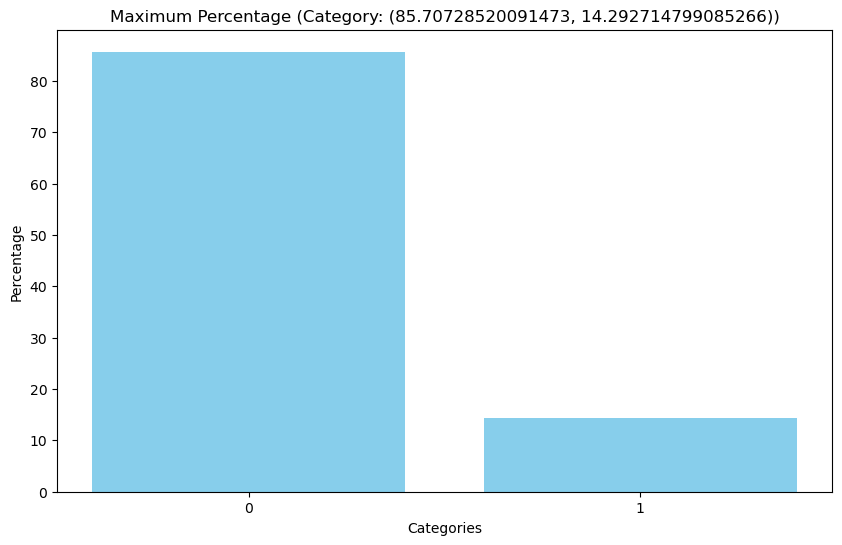

In [210]:
# Find the variable with the maximum percentage of 1
max_percentage_variable = max(percentage_0_1, key=lambda x: x[1])

# Bar plot for the variable with maximum percentage of 1
plt.figure(figsize=(10, 6))
plt.bar(['0', '1'], max_percentage_variable, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Percentage')
plt.title(f'Maximum Percentage (Category: {max_percentage_variable})')
plt.show()


In [199]:
# Extract counts for each variable
counts = {
    'VVL Mobile': df['VVL Mobile'].value_counts(),
    'VVL DSL': df['VVL DSL'].value_counts(),
    'PO GA': df['PO GA'].value_counts(),
    'I@H GA': df['I@H GA'].value_counts(),
    'TV GA': df['TV GA'].value_counts(),
}

# Find the variable with maximum sales
max_sales_variable = max(counts, key=lambda k: counts[k][1])

# Create a new target variable based on the variable with maximum sales
df['new target'] = df[max_sales_variable]

# Print the variable with maximum sales
print(f"The maximum sale is: {max_sales_variable}")

The maximum sale is: PO GA
